In [1]:
#Imports
import numpy as np
import tifffile as tle
import matplotlib.pyplot as plt
import keras
from keras.utils import to_categorical
import os
import time
from keras.layers import *
from keras.models import Model
from keras.callbacks import *
from sklearn.metrics import confusion_matrix
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
from keras.layers.normalization import BatchNormalization


/home/rithwik/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import tifffile as tiff
import os
from keras.utils import to_categorical
from skimage import io

In [3]:
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
smooth = 1e-12

#Some metrics for evaluating the model
def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)






def cross_entropy_custom(y_true,y_pred):

    pos_loss = (y_true * K.log( K.clip(y_pred,K.epsilon(),None)) * 9)

    neg_loss = ((1 - y_true) * K.log( K.clip(1-y_pred,K.epsilon(),None)))

    return -K.mean(pos_loss + neg_loss)


def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)


In [4]:
#Architecture for the UNet
def get_unet():
    inputs = Input((96, 96, 5))
    inputs_2 = Input((96,96,1))
    inputs_3 = Input((96,96,1))


    conv1 = Conv2D(32, 3, activation='elu', padding='same',data_format='channels_last')(inputs)
    conv1 = Conv2D(32, 3, activation='elu', padding='same')(conv1)

    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='elu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='elu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)

    conv3 = BatchNormalization()(conv3)


    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256,  3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up_1 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up_1, conv4])


    conv6 = Conv2D(256,  3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256,  3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128,  3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2] )
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64,  3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32, 3, activation='elu', padding='same')(up9)
    conv9 = Conv2D(32,  3, activation='elu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)


    conv11 = Conv2D(64, 3, activation='elu', padding='same')(inputs_3)
    conv12 = Conv2D(64, 3, activation='elu', padding='same')(conv11)


    conv9 = concatenate([conv9,inputs_2,conv12])
    conv9 = BatchNormalization()(conv9)




    conv10 = Conv2D(10, 1,  activation='softmax')(conv9)

    model = Model(input=[inputs,inputs_2,inputs_3], output=conv10)




    return model


In [17]:
#Function to generate the output given the input image. It patches and returns the output
def generate_whole_mask(img_path,weights_path):
    
    patch_size = 96
    
    model = get_unet()
    #print (weights_path)
    model.load_weights(weights_path)
    img = tiff.imread(img_path)
    im = np.copy(img)
    
    image=im[:,:,:]
    #print (img.shape)

    loop_1 =  img.shape[1]//patch_size
    loop_2 =  img.shape[0]//patch_size
        
    
    preds_arr = np.zeros((  img.shape[0] , img.shape[1] )) 
    true_arr = tiff.imread("arrays/train_y/"+img_name)

    

    for h in range(loop_2):
        for w in range(loop_1):


            common_img = im[h*patch_size:(h+1)*patch_size,w*patch_size:(w+1)*patch_size,:]

            common_img = (common_img)/ 4096.0

            p1 = np.expand_dims(common_img[:,:,4],axis=2)
            p2 = np.expand_dims(common_img[:,:,3],axis=2)


            pred = model.predict([np.expand_dims(common_img,axis=0),np.expand_dims(p1,axis=0),np.expand_dims(p2,axis=0)])[0]

            #print (pred.shape)

            pred[:,:,8] = 0

            pred = np.argmax(pred,axis=2)
            
            
            preds_arr[h*patch_size:(h+1)*patch_size,w*patch_size:(w+1)*patch_size] = pred




    return preds_arr,true_arr
            

In [18]:
#Function to convert th eoutput sof neural network to the color coding described in the dataset
def inverse_map(pred):
    pred = np.uint8(pred)
    pred = pred[..., np.newaxis]
    pred = np.where(pred == [10], [0, 0, 0], pred)
    pred = np.where(pred == [0], [0, 0, 0], pred)
    pred = np.where(pred == [1], [150, 80, 0], pred)
    pred = np.where(pred == [2], [0, 125, 0], pred)
    pred = np.where(pred == [3], [0, 255, 0], pred)
    pred = np.where(pred == [4], [100, 100, 100], pred)
    pred = np.where(pred == [5], [0, 0, 150], pred)
    pred = np.where(pred == [6], [200, 200, 200], pred)
    pred = np.where(pred == [7], [150, 150, 255], pred)
    pred = np.where(pred == [8], [255, 255, 255], pred)
    pred = np.where(pred == [9], [255, 255, 0], pred)
    return pred

Running for Image 1


/home/rithwik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("co...)`


Train on 1324 samples, validate on 568 samples
Epoch 1/30
1324/1324 [==============================] - 11s 8ms/step - loss: 1.6794 - jaccard_coef: 0.1657 - jaccard_coef_int: 0.0846 - acc: 0.4530 - val_loss: 2.5173 - val_jaccard_coef: 0.1815 - val_jaccard_coef_int: 0.1655 - val_acc: 0.3204

Epoch 00001: val_acc improved from -inf to 0.32041, saving model to ../cv_weights/cv_weights_v_1.best.hdf5
Epoch 2/30
1324/1324 [==============================] - 5s 4ms/step - loss: 1.1715 - jaccard_coef: 0.2660 - jaccard_coef_int: 0.2155 - acc: 0.6346 - val_loss: 1.4115 - val_jaccard_coef: 0.2263 - val_jaccard_coef_int: 0.2022 - val_acc: 0.5325

Epoch 00002: val_acc improved from 0.32041 to 0.53247, saving model to ../cv_weights/cv_weights_v_1.best.hdf5
Epoch 3/30
1324/1324 [==============================] - 5s 4ms/step - loss: 0.9855 - jaccard_coef: 0.3341 - jaccard_coef_int: 0.3421 - acc: 0.6846 - val_loss: 1.0380 - val_jaccard_coef: 0.3517 - val_jaccard_coef_int: 0.4076 - val_acc: 0.6583

Epoch 

1324/1324 [==============================] - 5s 4ms/step - loss: 0.4278 - jaccard_coef: 0.6075 - jaccard_coef_int: 0.6915 - acc: 0.8295 - val_loss: 0.7941 - val_jaccard_coef: 0.5118 - val_jaccard_coef_int: 0.5552 - val_acc: 0.7289

Epoch 00027: val_acc did not improve from 0.75738
Epoch 28/30
1324/1324 [==============================] - 5s 4ms/step - loss: 0.4573 - jaccard_coef: 0.5899 - jaccard_coef_int: 0.6725 - acc: 0.8176 - val_loss: 0.7566 - val_jaccard_coef: 0.5236 - val_jaccard_coef_int: 0.5668 - val_acc: 0.7376

Epoch 00028: val_acc did not improve from 0.75738
Epoch 29/30
1324/1324 [==============================] - 5s 4ms/step - loss: 0.4262 - jaccard_coef: 0.6077 - jaccard_coef_int: 0.6904 - acc: 0.8299 - val_loss: 0.6818 - val_jaccard_coef: 0.5419 - val_jaccard_coef_int: 0.5908 - val_acc: 0.7548

Epoch 00029: val_acc did not improve from 0.75738
Epoch 30/30
1324/1324 [==============================] - 5s 4ms/step - loss: 0.4091 - jaccard_coef: 0.6211 - jaccard_coef_int: 0.7

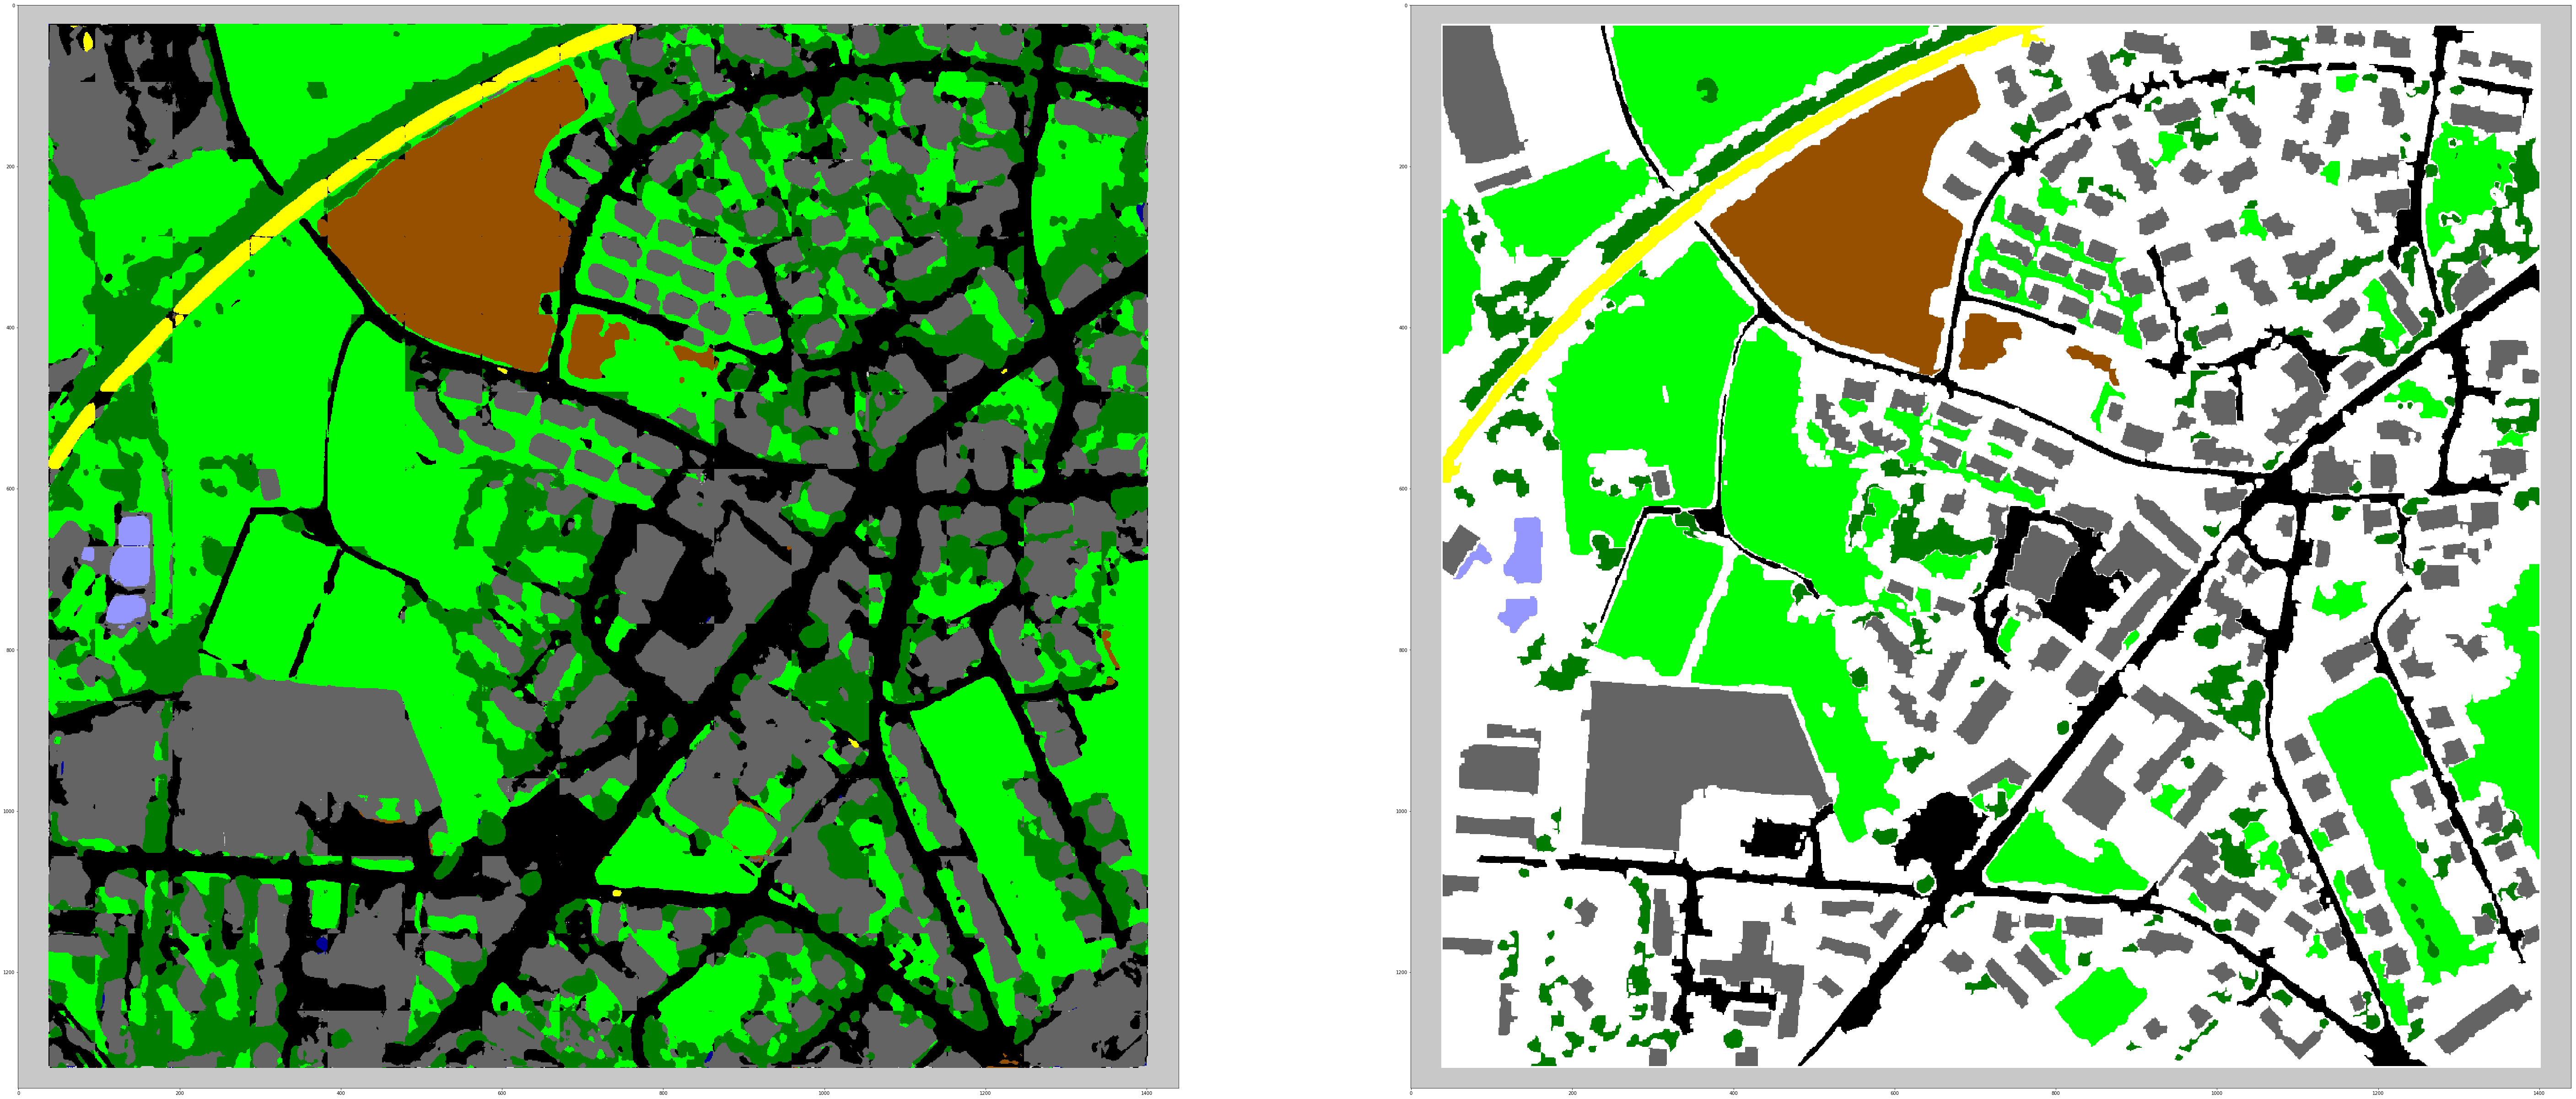

[[117775    116    321    256   1894      0      0    164]
 [   402  71595      0    419     13      0      0      0]
 [   393      0  73642   4764    344      2      0      3]
 [   547     20   4186 306442    637      1      0      0]
 [  3309     21   1221    463 245958      0      0    231]
 [     0      0      0      0      0      0      0      0]
 [   202      0      0      0    406     22   4397      0]
 [   740     13    193     49    376      6      0  14656]]
Accuracy is 0.9746157143374379 while leaving Image1
Running for Image 2
Train on 1276 samples, validate on 548 samples
Epoch 1/30
1276/1276 [==============================] - 10s 8ms/step - loss: 1.7438 - jaccard_coef: 0.1537 - jaccard_coef_int: 0.0707 - acc: 0.4208 - val_loss: 1.6506 - val_jaccard_coef: 0.2172 - val_jaccard_coef_int: 0.2037 - val_acc: 0.3863

Epoch 00001: val_acc improved from -inf to 0.38628, saving model to ../cv_weights/cv_weights_v_2.best.hdf5
Epoch 2/30
1276/1276 [==============================] - 5

Epoch 25/30
1276/1276 [==============================] - 4s 4ms/step - loss: 0.4764 - jaccard_coef: 0.5718 - jaccard_coef_int: 0.6536 - acc: 0.8084 - val_loss: 0.8956 - val_jaccard_coef: 0.5173 - val_jaccard_coef_int: 0.5516 - val_acc: 0.7205

Epoch 00025: val_acc improved from 0.72038 to 0.72055, saving model to ../cv_weights/cv_weights_v_2.best.hdf5
Epoch 26/30
1276/1276 [==============================] - 4s 4ms/step - loss: 0.4583 - jaccard_coef: 0.5804 - jaccard_coef_int: 0.6670 - acc: 0.8164 - val_loss: 0.8558 - val_jaccard_coef: 0.5199 - val_jaccard_coef_int: 0.5542 - val_acc: 0.7244

Epoch 00026: val_acc improved from 0.72055 to 0.72440, saving model to ../cv_weights/cv_weights_v_2.best.hdf5
Epoch 27/30
1276/1276 [==============================] - 4s 4ms/step - loss: 0.4415 - jaccard_coef: 0.5952 - jaccard_coef_int: 0.6817 - acc: 0.8245 - val_loss: 0.8909 - val_jaccard_coef: 0.5158 - val_jaccard_coef_int: 0.5520 - val_acc: 0.7261

Epoch 00027: val_acc improved from 0.72440 to 0.

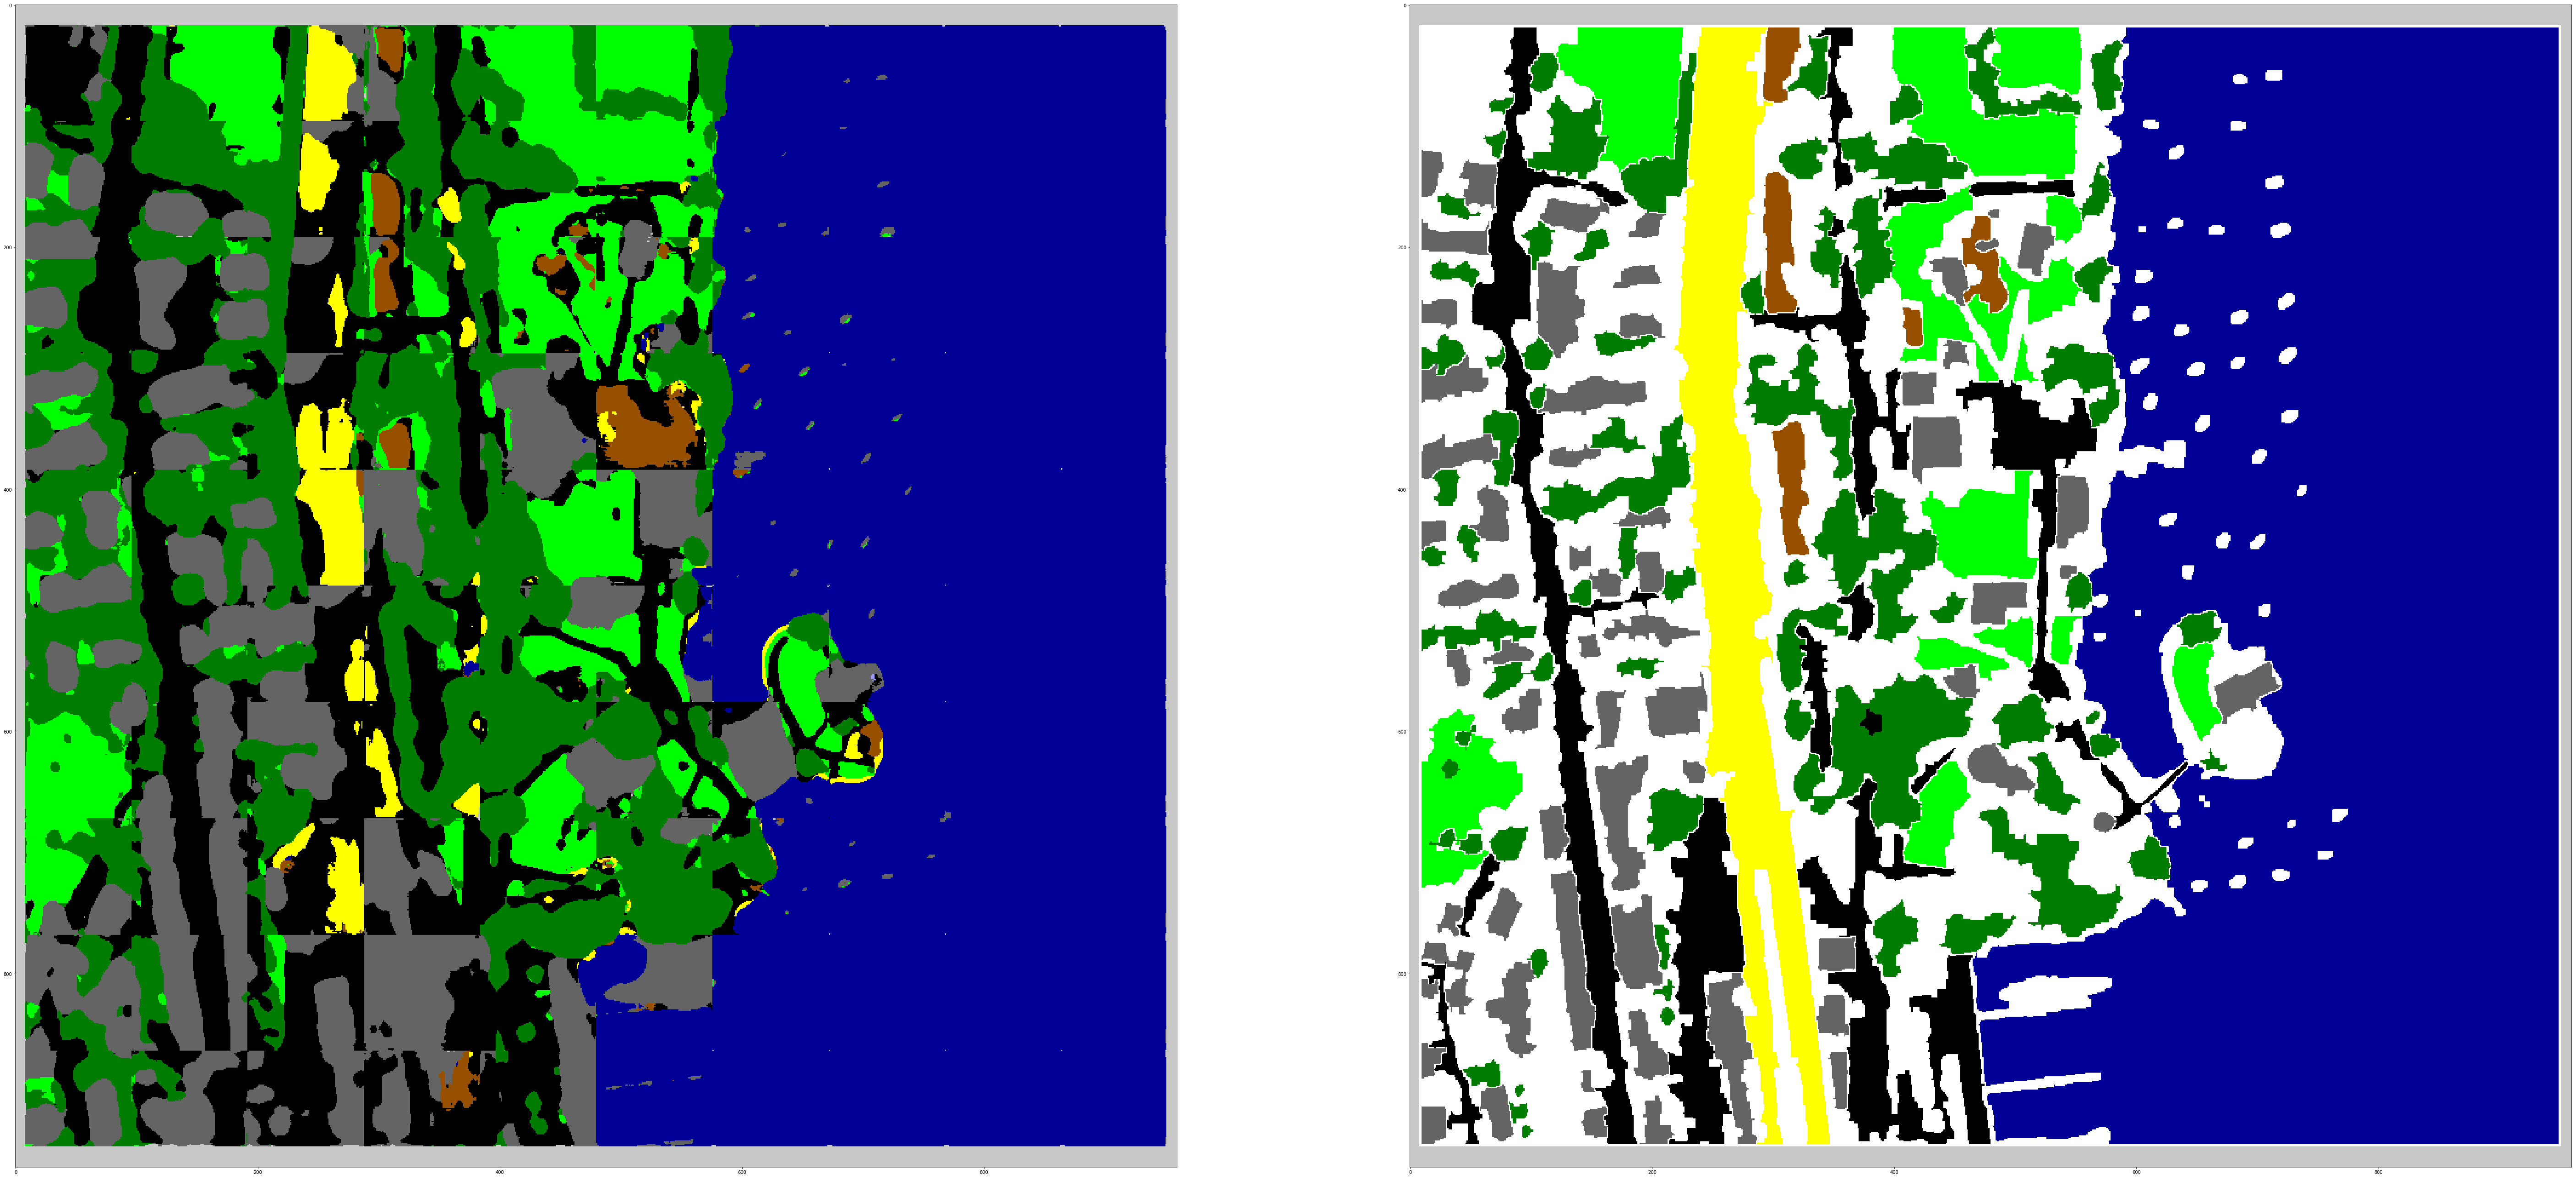

[[ 50822   3893   1343    870   7477     16      0   1568]
 [  1047   3289      1   1419   1933      0      0      0]
 [  2488      6  67330   1534   1293     57      0    216]
 [  1221      2   1216  47355     38      0      0      0]
 [  5420    504    710    144  47182     18     14      0]
 [  1191     14    359     96   5144 326868      0    312]
 [     0      0      0      0      0      0      0      0]
 [ 19146     13   1017     54  10209      0      0  12111]]
Accuracy is 0.8851553528135766 while leaving Image2
Running for Image 3
Train on 1433 samples, validate on 615 samples
Epoch 1/30
1433/1433 [==============================] - 11s 8ms/step - loss: 1.6814 - jaccard_coef: 0.1599 - jaccard_coef_int: 0.0931 - acc: 0.4379 - val_loss: 1.7292 - val_jaccard_coef: 0.1633 - val_jaccard_coef_int: 0.0853 - val_acc: 0.4156

Epoch 00001: val_acc improved from -inf to 0.41563, saving model to ../cv_weights/cv_weights_v_3.best.hdf5
Epoch 2/30
1433/1433 [==============================] - 5

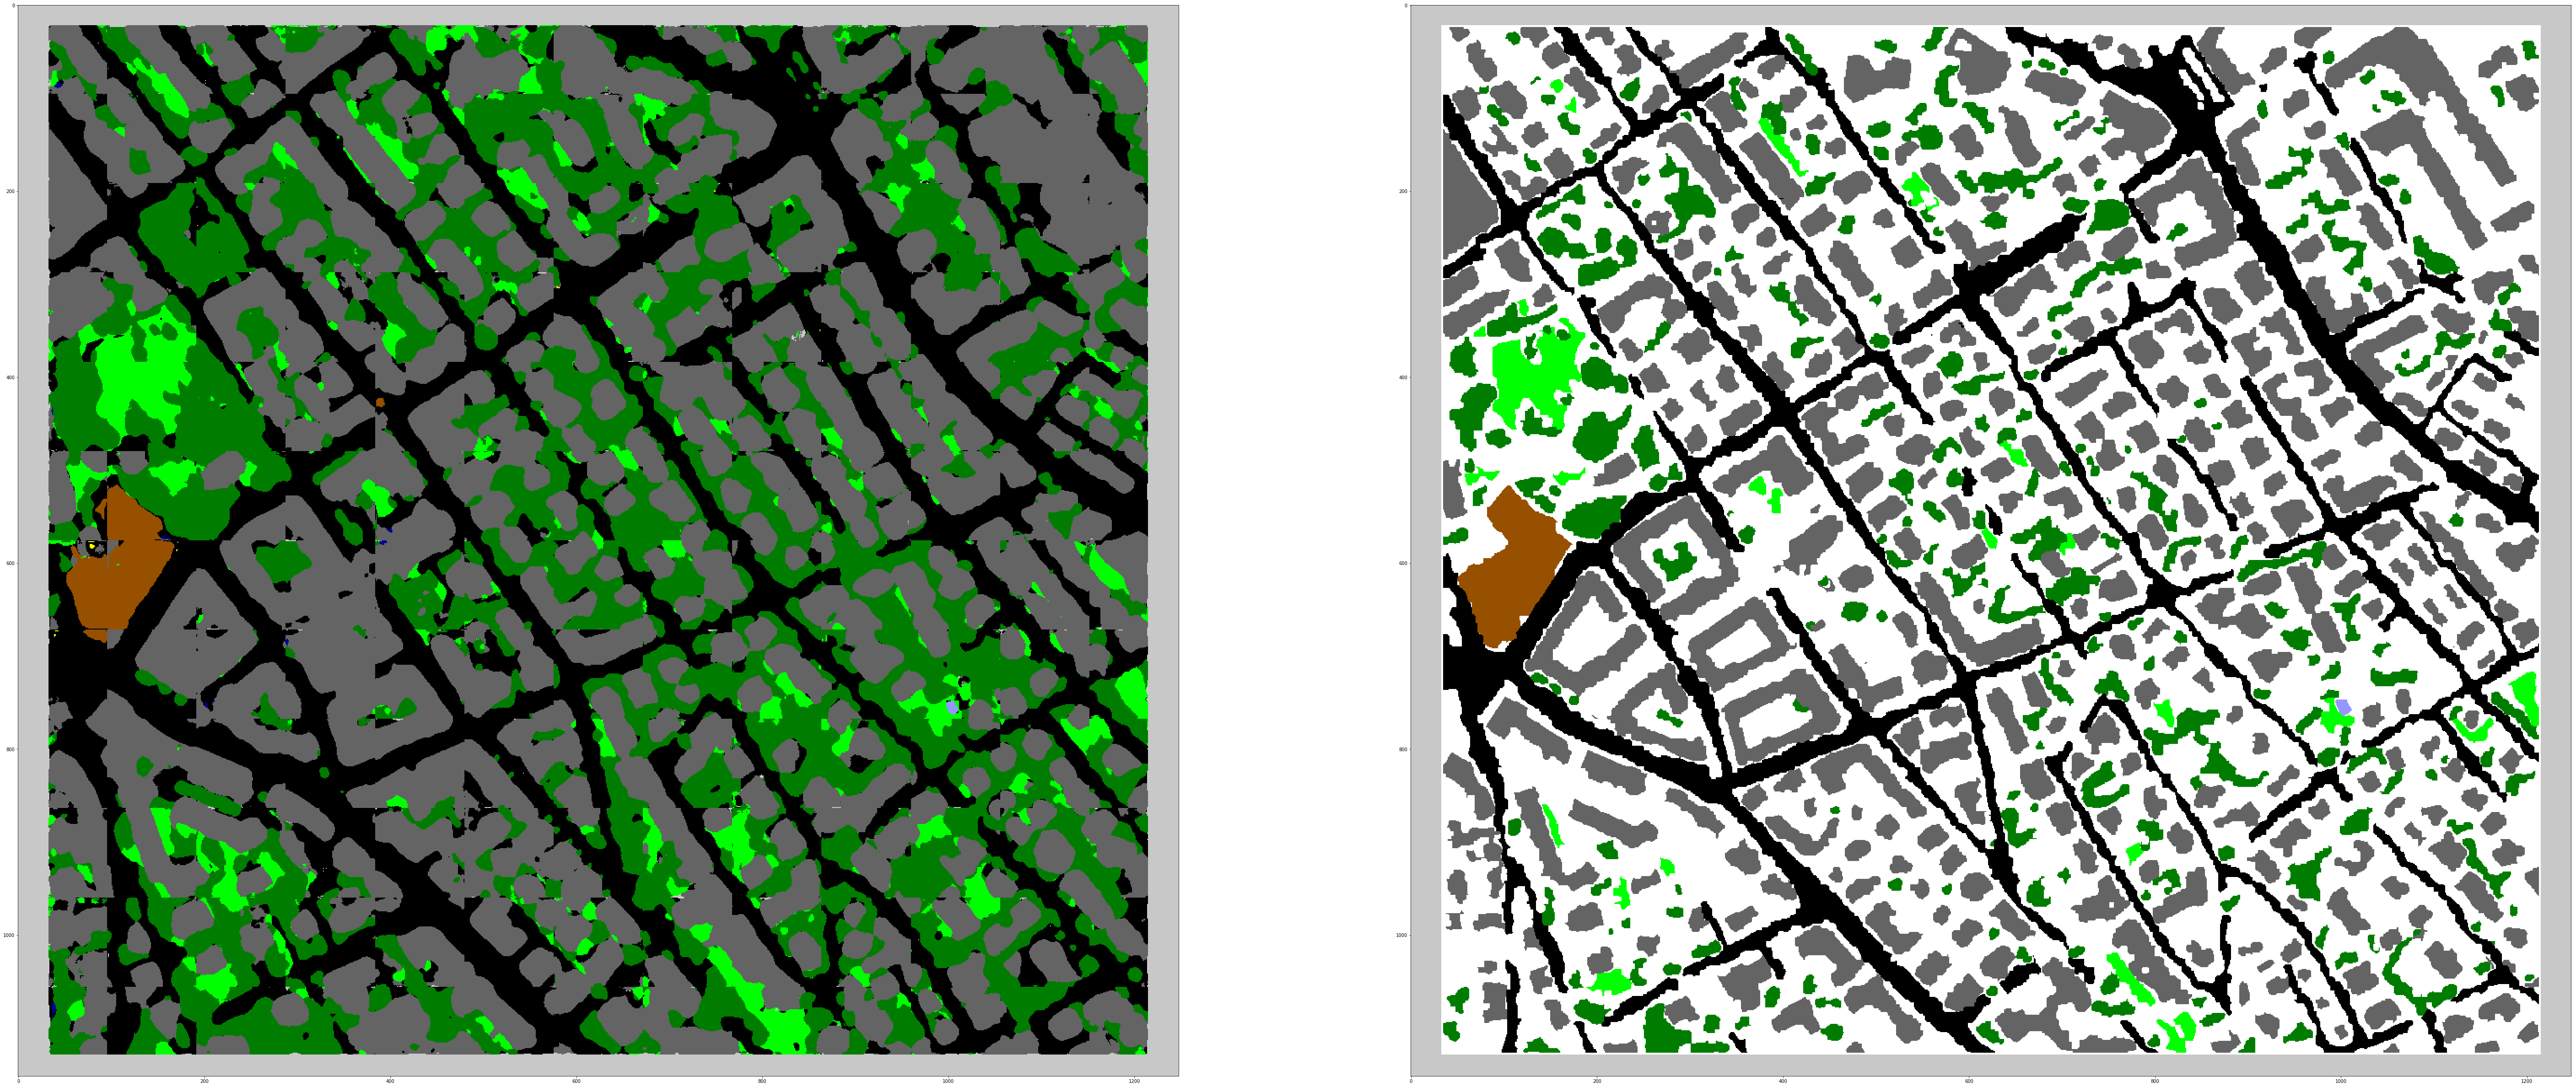

[[166382    188   1605     86   5162      0      0      6]
 [   802   9585      1      5    278     24      0      0]
 [   653      0  90767   1136   1003      0      0      0]
 [     5      0    821  15802    187      0      0      0]
 [  3602      0   1378    368 311627      0      0      6]
 [     0      0      0      0      0      0      0      0]
 [     7      0      0     69      0      0    139      0]
 [     0      0      0      0      0      0      0      0]]
Accuracy is 0.9715674830879492 while leaving Image3
Running for Image 4
Train on 1459 samples, validate on 626 samples
Epoch 1/30
1459/1459 [==============================] - 11s 7ms/step - loss: 1.6398 - jaccard_coef: 0.1778 - jaccard_coef_int: 0.1188 - acc: 0.4565 - val_loss: 1.4306 - val_jaccard_coef: 0.2488 - val_jaccard_coef_int: 0.2214 - val_acc: 0.4660

Epoch 00001: val_acc improved from -inf to 0.46605, saving model to ../cv_weights/cv_weights_v_4.best.hdf5
Epoch 2/30
1459/1459 [==============================] - 5

1459/1459 [==============================] - 5s 3ms/step - loss: 0.4808 - jaccard_coef: 0.5744 - jaccard_coef_int: 0.6531 - acc: 0.8080 - val_loss: 0.8492 - val_jaccard_coef: 0.4936 - val_jaccard_coef_int: 0.5320 - val_acc: 0.7115

Epoch 00025: val_acc did not improve from 0.72714
Epoch 26/30
1459/1459 [==============================] - 5s 4ms/step - loss: 0.4692 - jaccard_coef: 0.5777 - jaccard_coef_int: 0.6604 - acc: 0.8119 - val_loss: 0.8037 - val_jaccard_coef: 0.5007 - val_jaccard_coef_int: 0.5486 - val_acc: 0.7206

Epoch 00026: val_acc did not improve from 0.72714
Epoch 27/30
1459/1459 [==============================] - 5s 3ms/step - loss: 0.4519 - jaccard_coef: 0.5918 - jaccard_coef_int: 0.6717 - acc: 0.8184 - val_loss: 0.9085 - val_jaccard_coef: 0.4859 - val_jaccard_coef_int: 0.5186 - val_acc: 0.7008

Epoch 00027: val_acc did not improve from 0.72714
Epoch 28/30
1459/1459 [==============================] - 5s 3ms/step - loss: 0.4414 - jaccard_coef: 0.5965 - jaccard_coef_int: 0.6

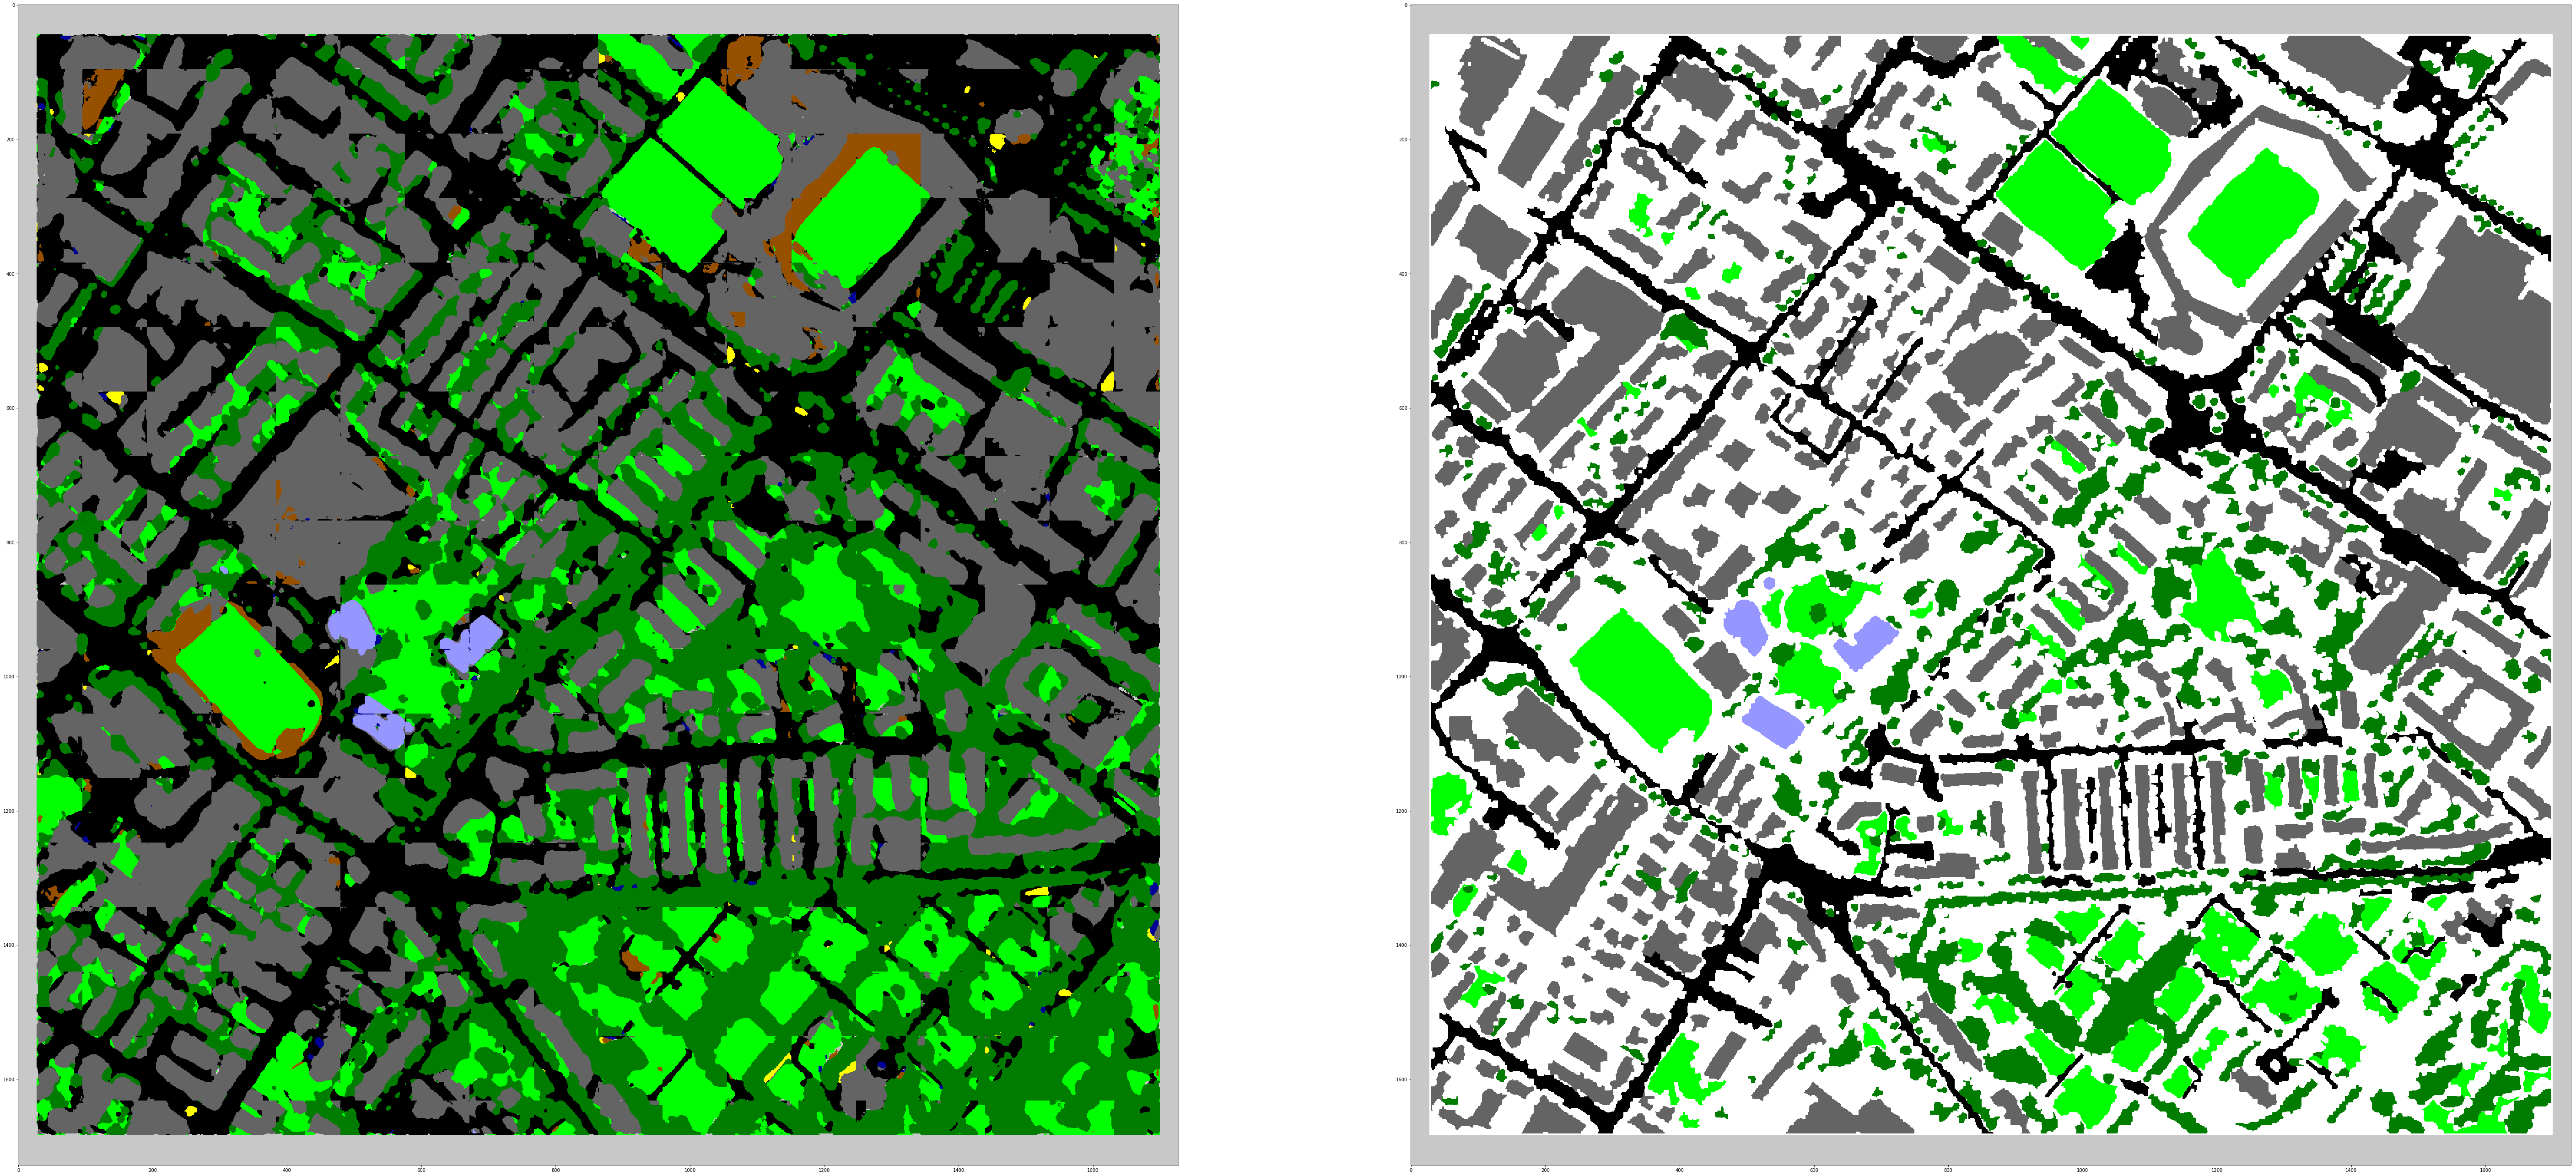

[[254122   4222   6343   1848  23392    106      0   1469]
 [     0      0      0      0      0      0      0      0]
 [  4233      2 220521   9539   1320      0      0     21]
 [  1603    668   8027 199032    732      1      0      8]
 [ 67565   4265   3423   2223 512469    145     22   1383]
 [     0      0      0      0      0      0      0      0]
 [   441      0     94     87    471    134  10307      0]
 [     0      0      0      0      0      0      0      0]]
Accuracy is 0.8927153236962391 while leaving Image4
Running for Image 5
Train on 1419 samples, validate on 609 samples
Epoch 1/30
1419/1419 [==============================] - 11s 8ms/step - loss: 1.6209 - jaccard_coef: 0.1757 - jaccard_coef_int: 0.1075 - acc: 0.4693 - val_loss: 4.7142 - val_jaccard_coef: 0.0899 - val_jaccard_coef_int: 0.0770 - val_acc: 0.1845

Epoch 00001: val_acc improved from -inf to 0.18447, saving model to ../cv_weights/cv_weights_v_5.best.hdf5
Epoch 2/30
1419/1419 [==============================] - 5

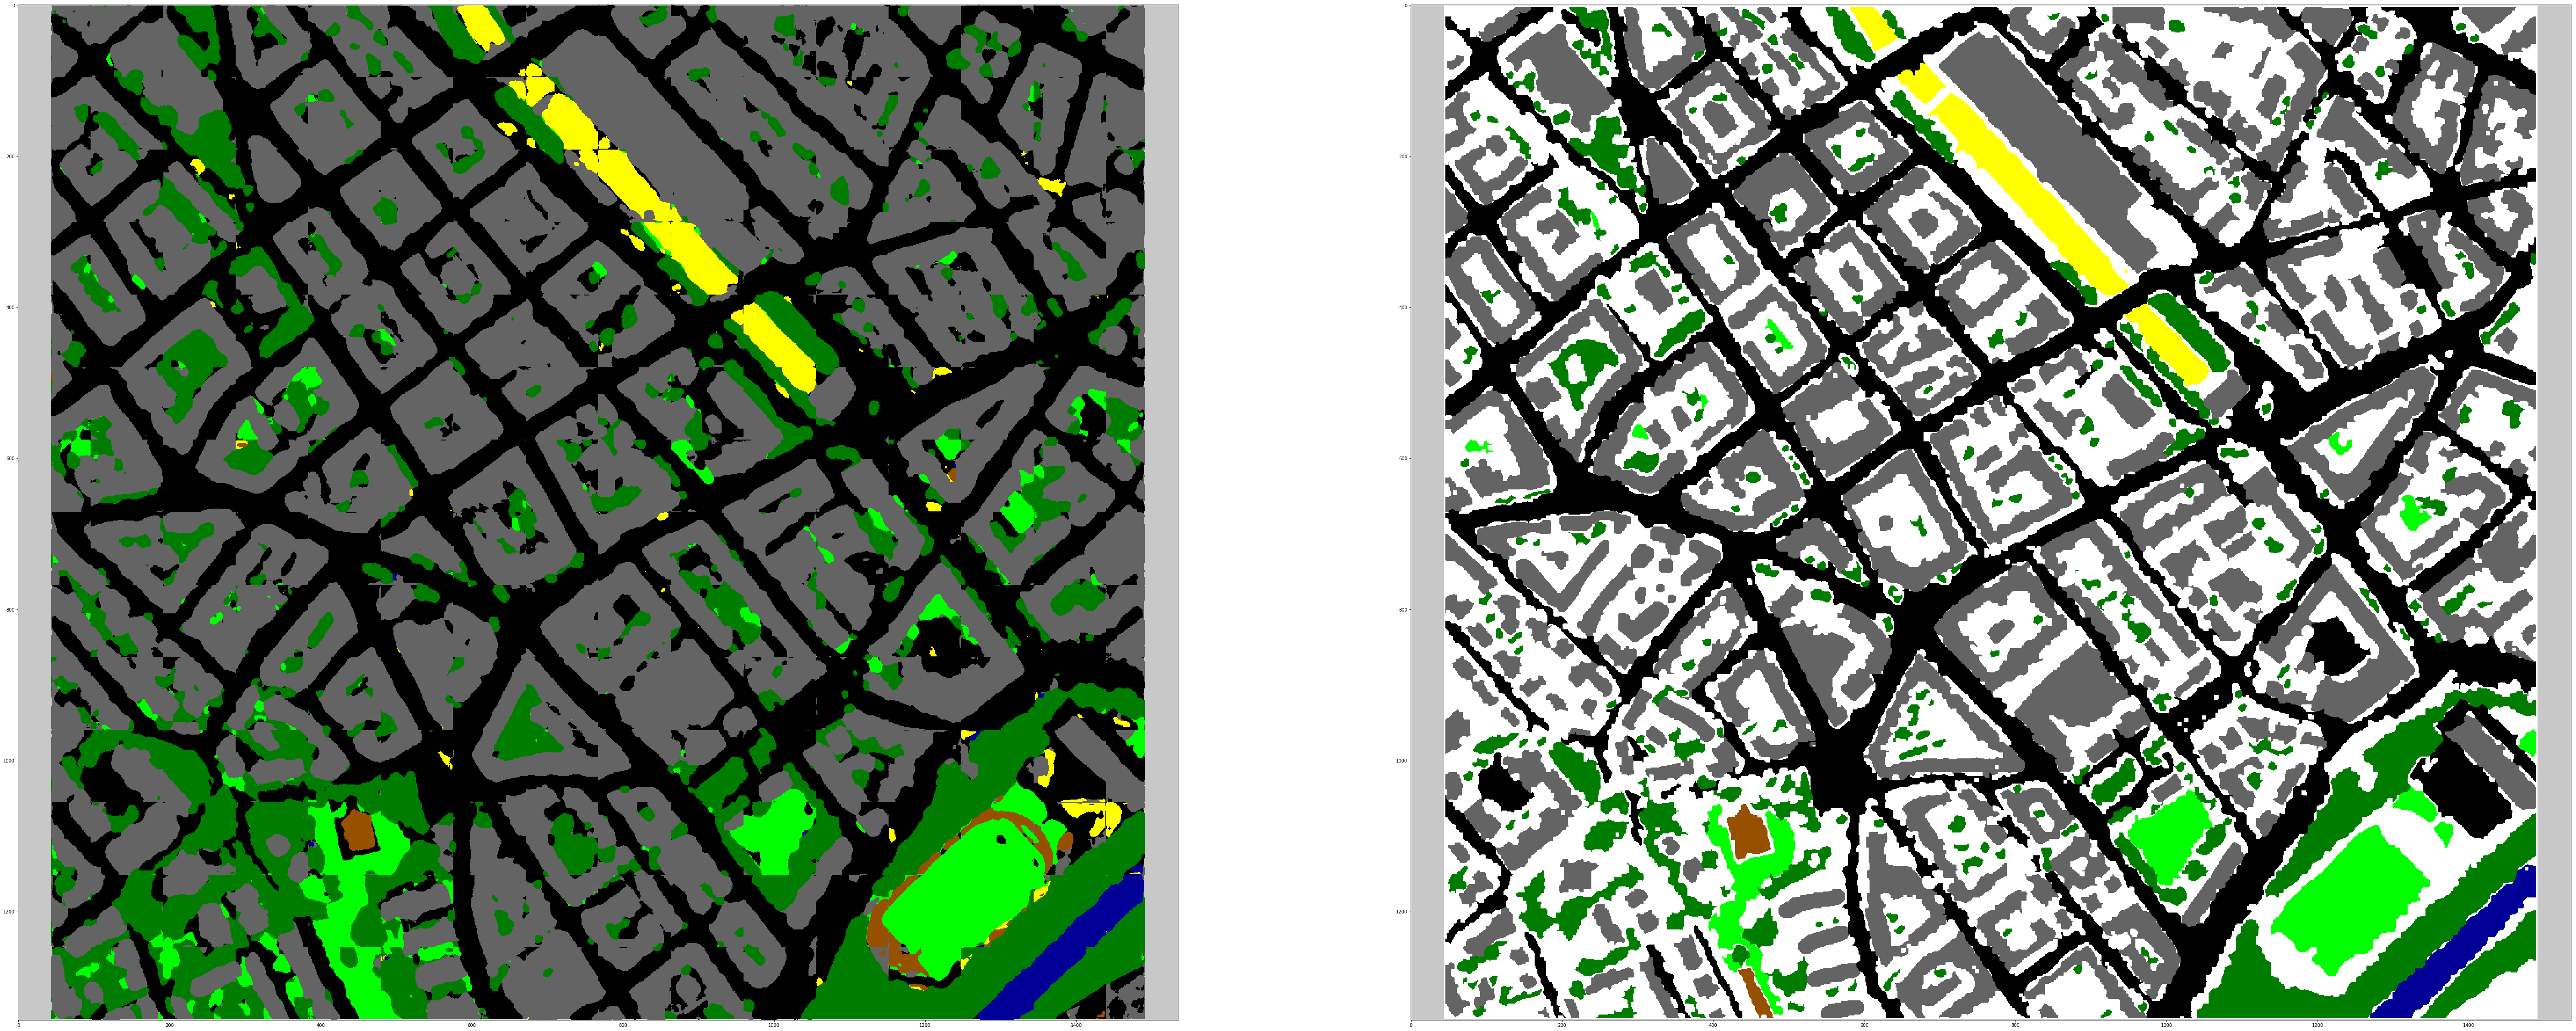

[[401960      3   1664     61  21200      0      0   4715]
 [   877   1715      0   1140      0      0      0      0]
 [  1150     33 148194    651    955     58      0    121]
 [   396    204   1741  40875    385     46      0     38]
 [ 10361     85   1171    254 542878      0      0     68]
 [    63      0    133      0     15   9935      0     26]
 [     0      0      0      0      0      0      0      0]
 [   641      0    107    119    814      1      0  20584]]
Accuracy is 0.9594417481119959 while leaving Image5
Running for Image 6
Train on 1394 samples, validate on 598 samples
Epoch 1/30
1394/1394 [==============================] - 11s 8ms/step - loss: 1.6701 - jaccard_coef: 0.1733 - jaccard_coef_int: 0.1109 - acc: 0.4294 - val_loss: 3.1363 - val_jaccard_coef: 0.1480 - val_jaccard_coef_int: 0.1371 - val_acc: 0.2999

Epoch 00001: val_acc improved from -inf to 0.29986, saving model to ../cv_weights/cv_weights_v_6.best.hdf5
Epoch 2/30
1394/1394 [==============================] - 5

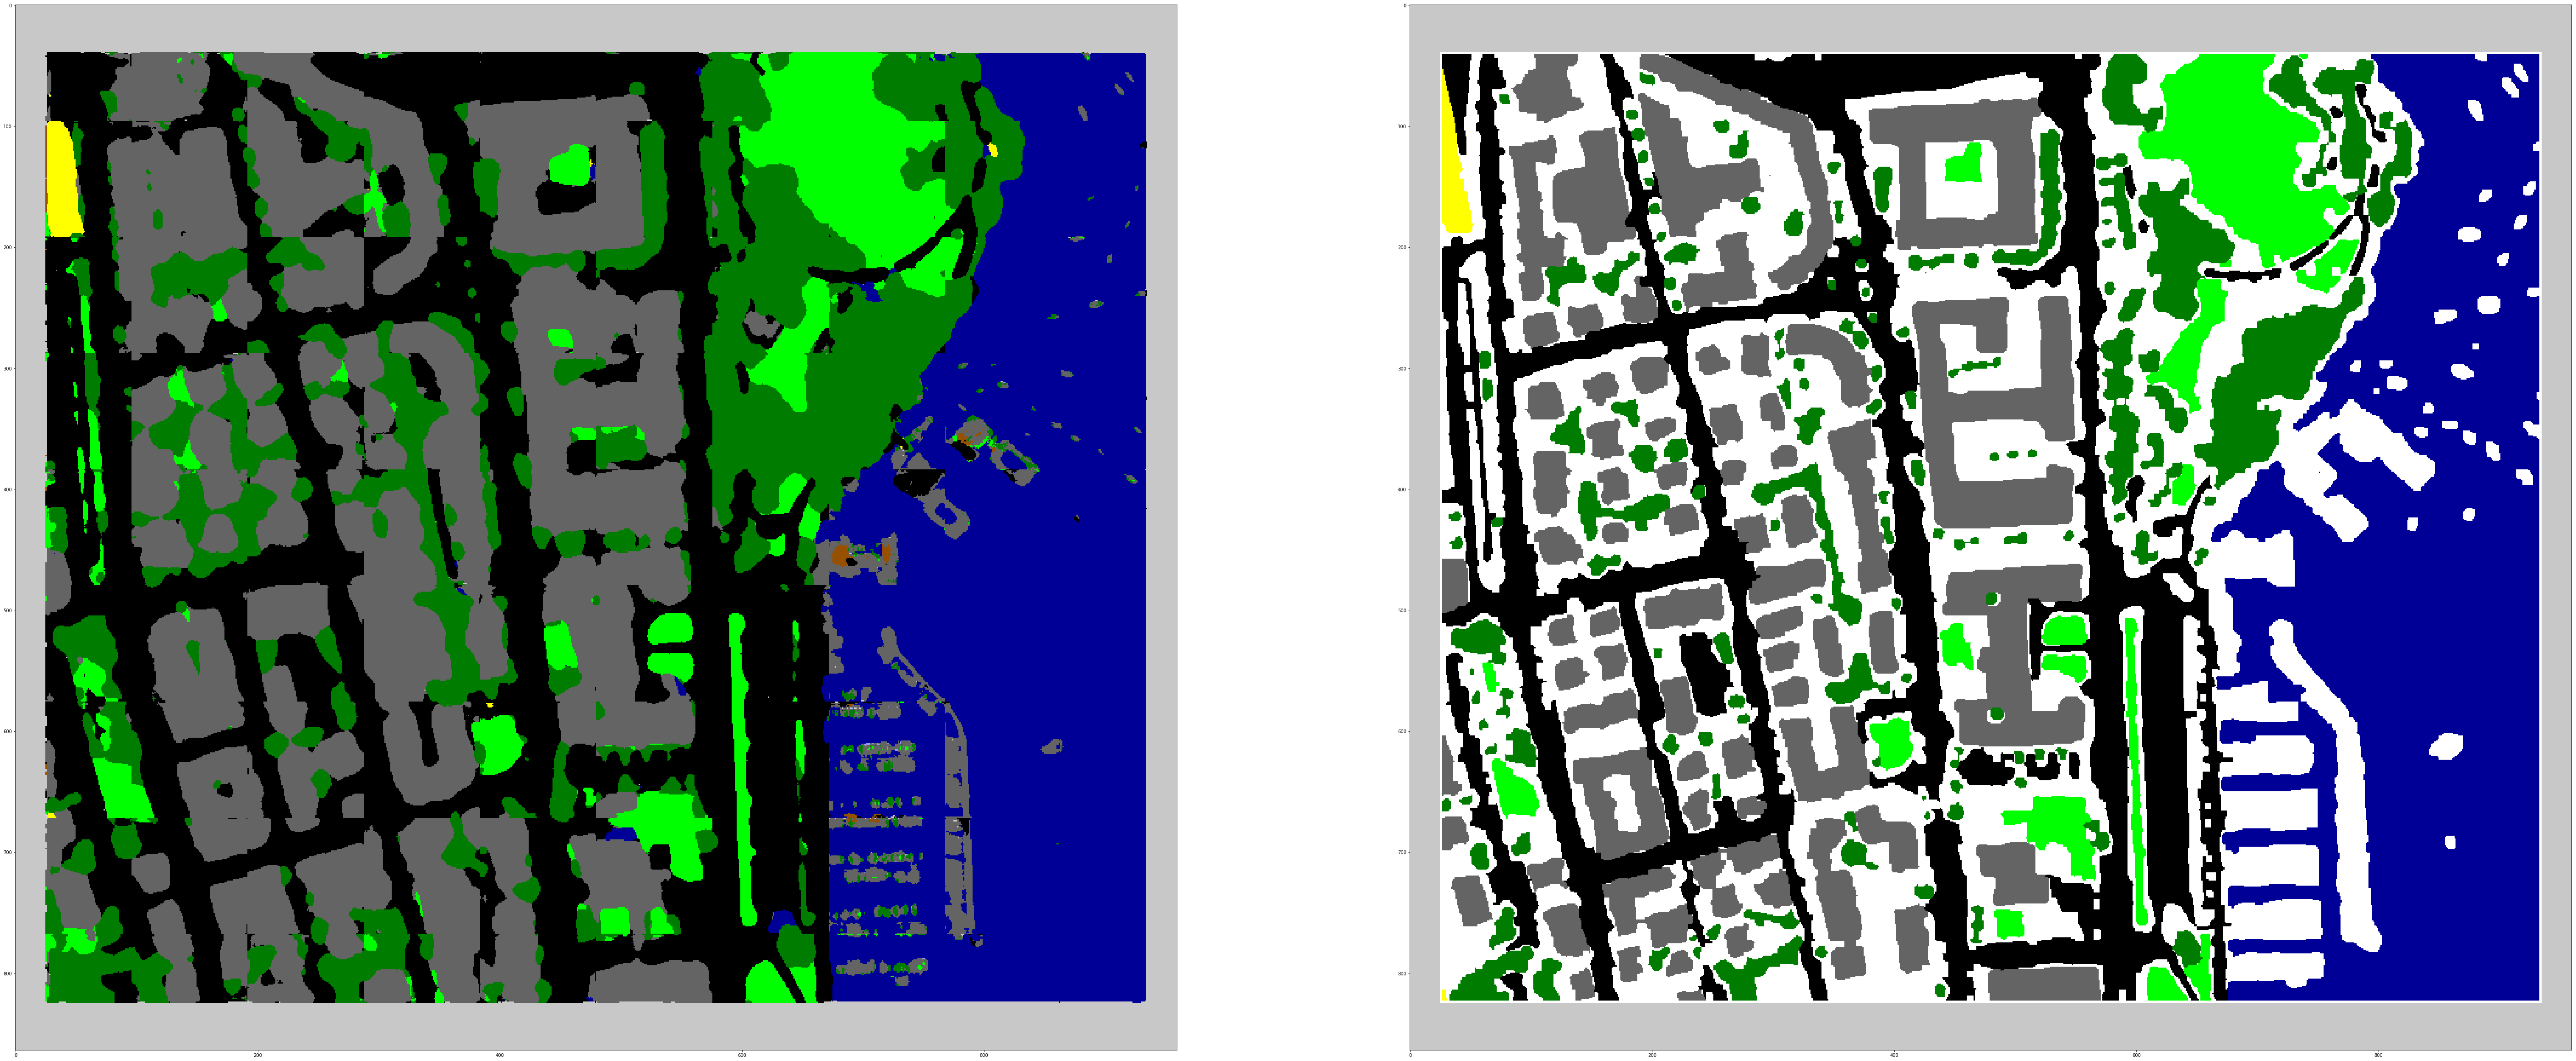

[[125823      0    280     49   2907    124      0    180]
 [     0      0      0      0      0      0      0      0]
 [   416      0  53492    538    249      0      0      0]
 [   156      0    651  30868    132     26      0      0]
 [  2273      0    276     27 119774      0      0      6]
 [    57      0     10      0    102 130559      0      0]
 [     0      0      0      0      0      0      0      0]
 [   155      0     23      6     68      0      0   1588]]
Accuracy is 0.9814980406316706 while leaving Image6
Running for Image 7
Train on 1426 samples, validate on 612 samples
Epoch 1/30
1426/1426 [==============================] - 12s 9ms/step - loss: 1.6375 - jaccard_coef: 0.1801 - jaccard_coef_int: 0.1219 - acc: 0.4697 - val_loss: 1.8237 - val_jaccard_coef: 0.1870 - val_jaccard_coef_int: 0.1010 - val_acc: 0.4454

Epoch 00001: val_acc improved from -inf to 0.44545, saving model to ../cv_weights/cv_weights_v_7.best.hdf5
Epoch 2/30
1426/1426 [==============================] - 5

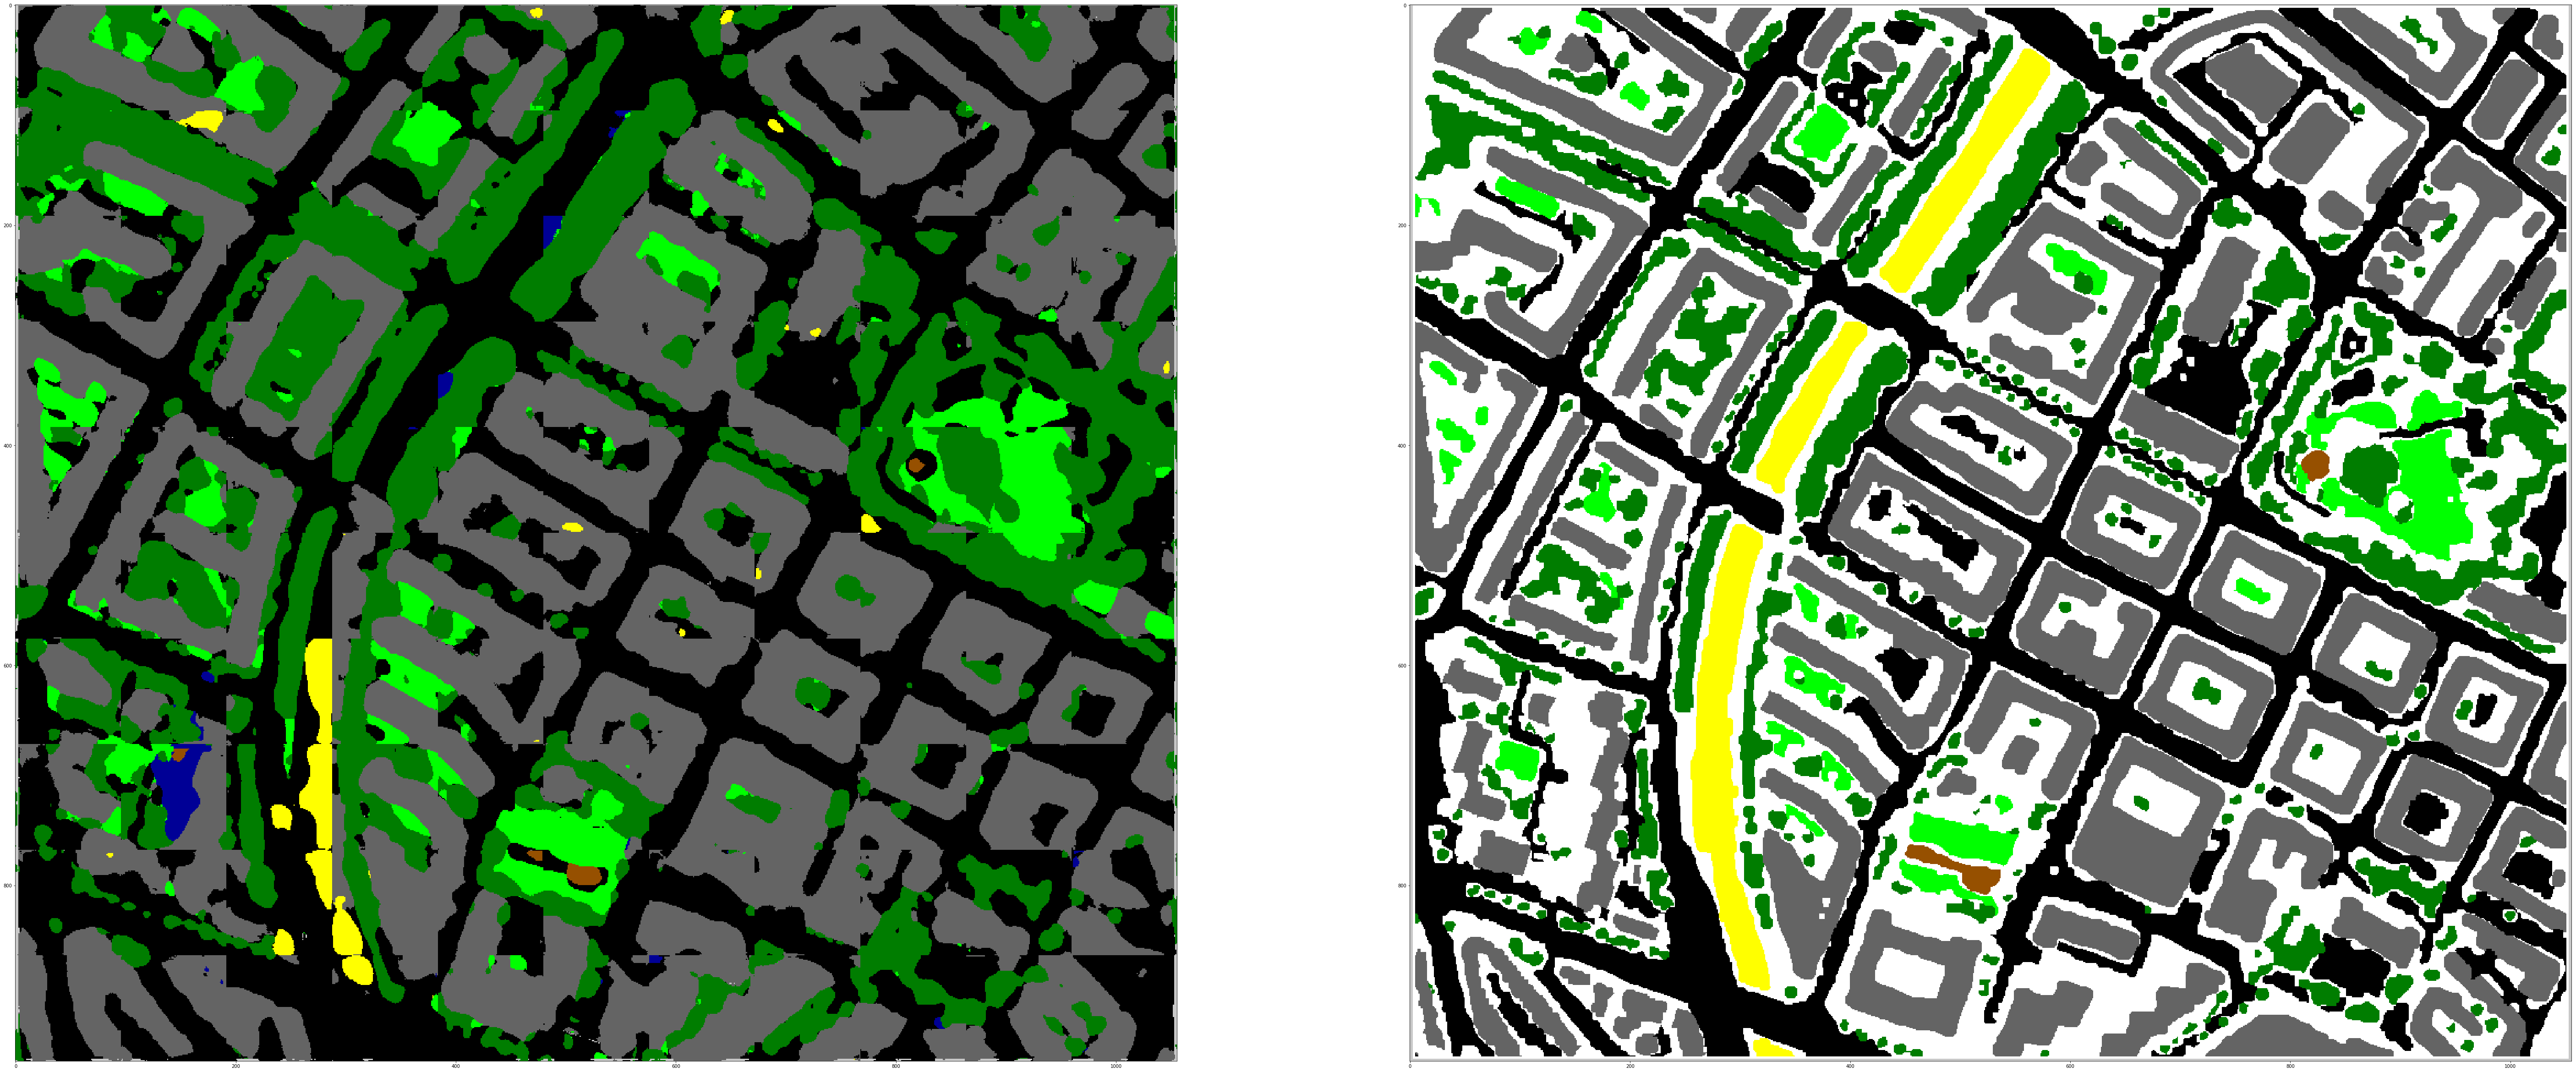

[[190206      0   6291    691  21108    455      0    939]
 [  1092    697      0     51      2      0      0      0]
 [  1197      0 108428    851    897      0      0      0]
 [   258      0   2395  23064     48      0      0      0]
 [ 13740      0    374   1354 255420     16      0    790]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [ 15183      0    342     18   3450    436      0   5823]]
Accuracy is 0.8902131735650136 while leaving Image7
Running for Image 8
Train on 1440 samples, validate on 618 samples
Epoch 1/30
1440/1440 [==============================] - 12s 8ms/step - loss: 1.5858 - jaccard_coef: 0.1785 - jaccard_coef_int: 0.1044 - acc: 0.4858 - val_loss: 1.7668 - val_jaccard_coef: 0.2438 - val_jaccard_coef_int: 0.2471 - val_acc: 0.5005

Epoch 00001: val_acc improved from -inf to 0.50049, saving model to ../cv_weights/cv_weights_v_8.best.hdf5
Epoch 2/30
1440/1440 [==============================] - 5

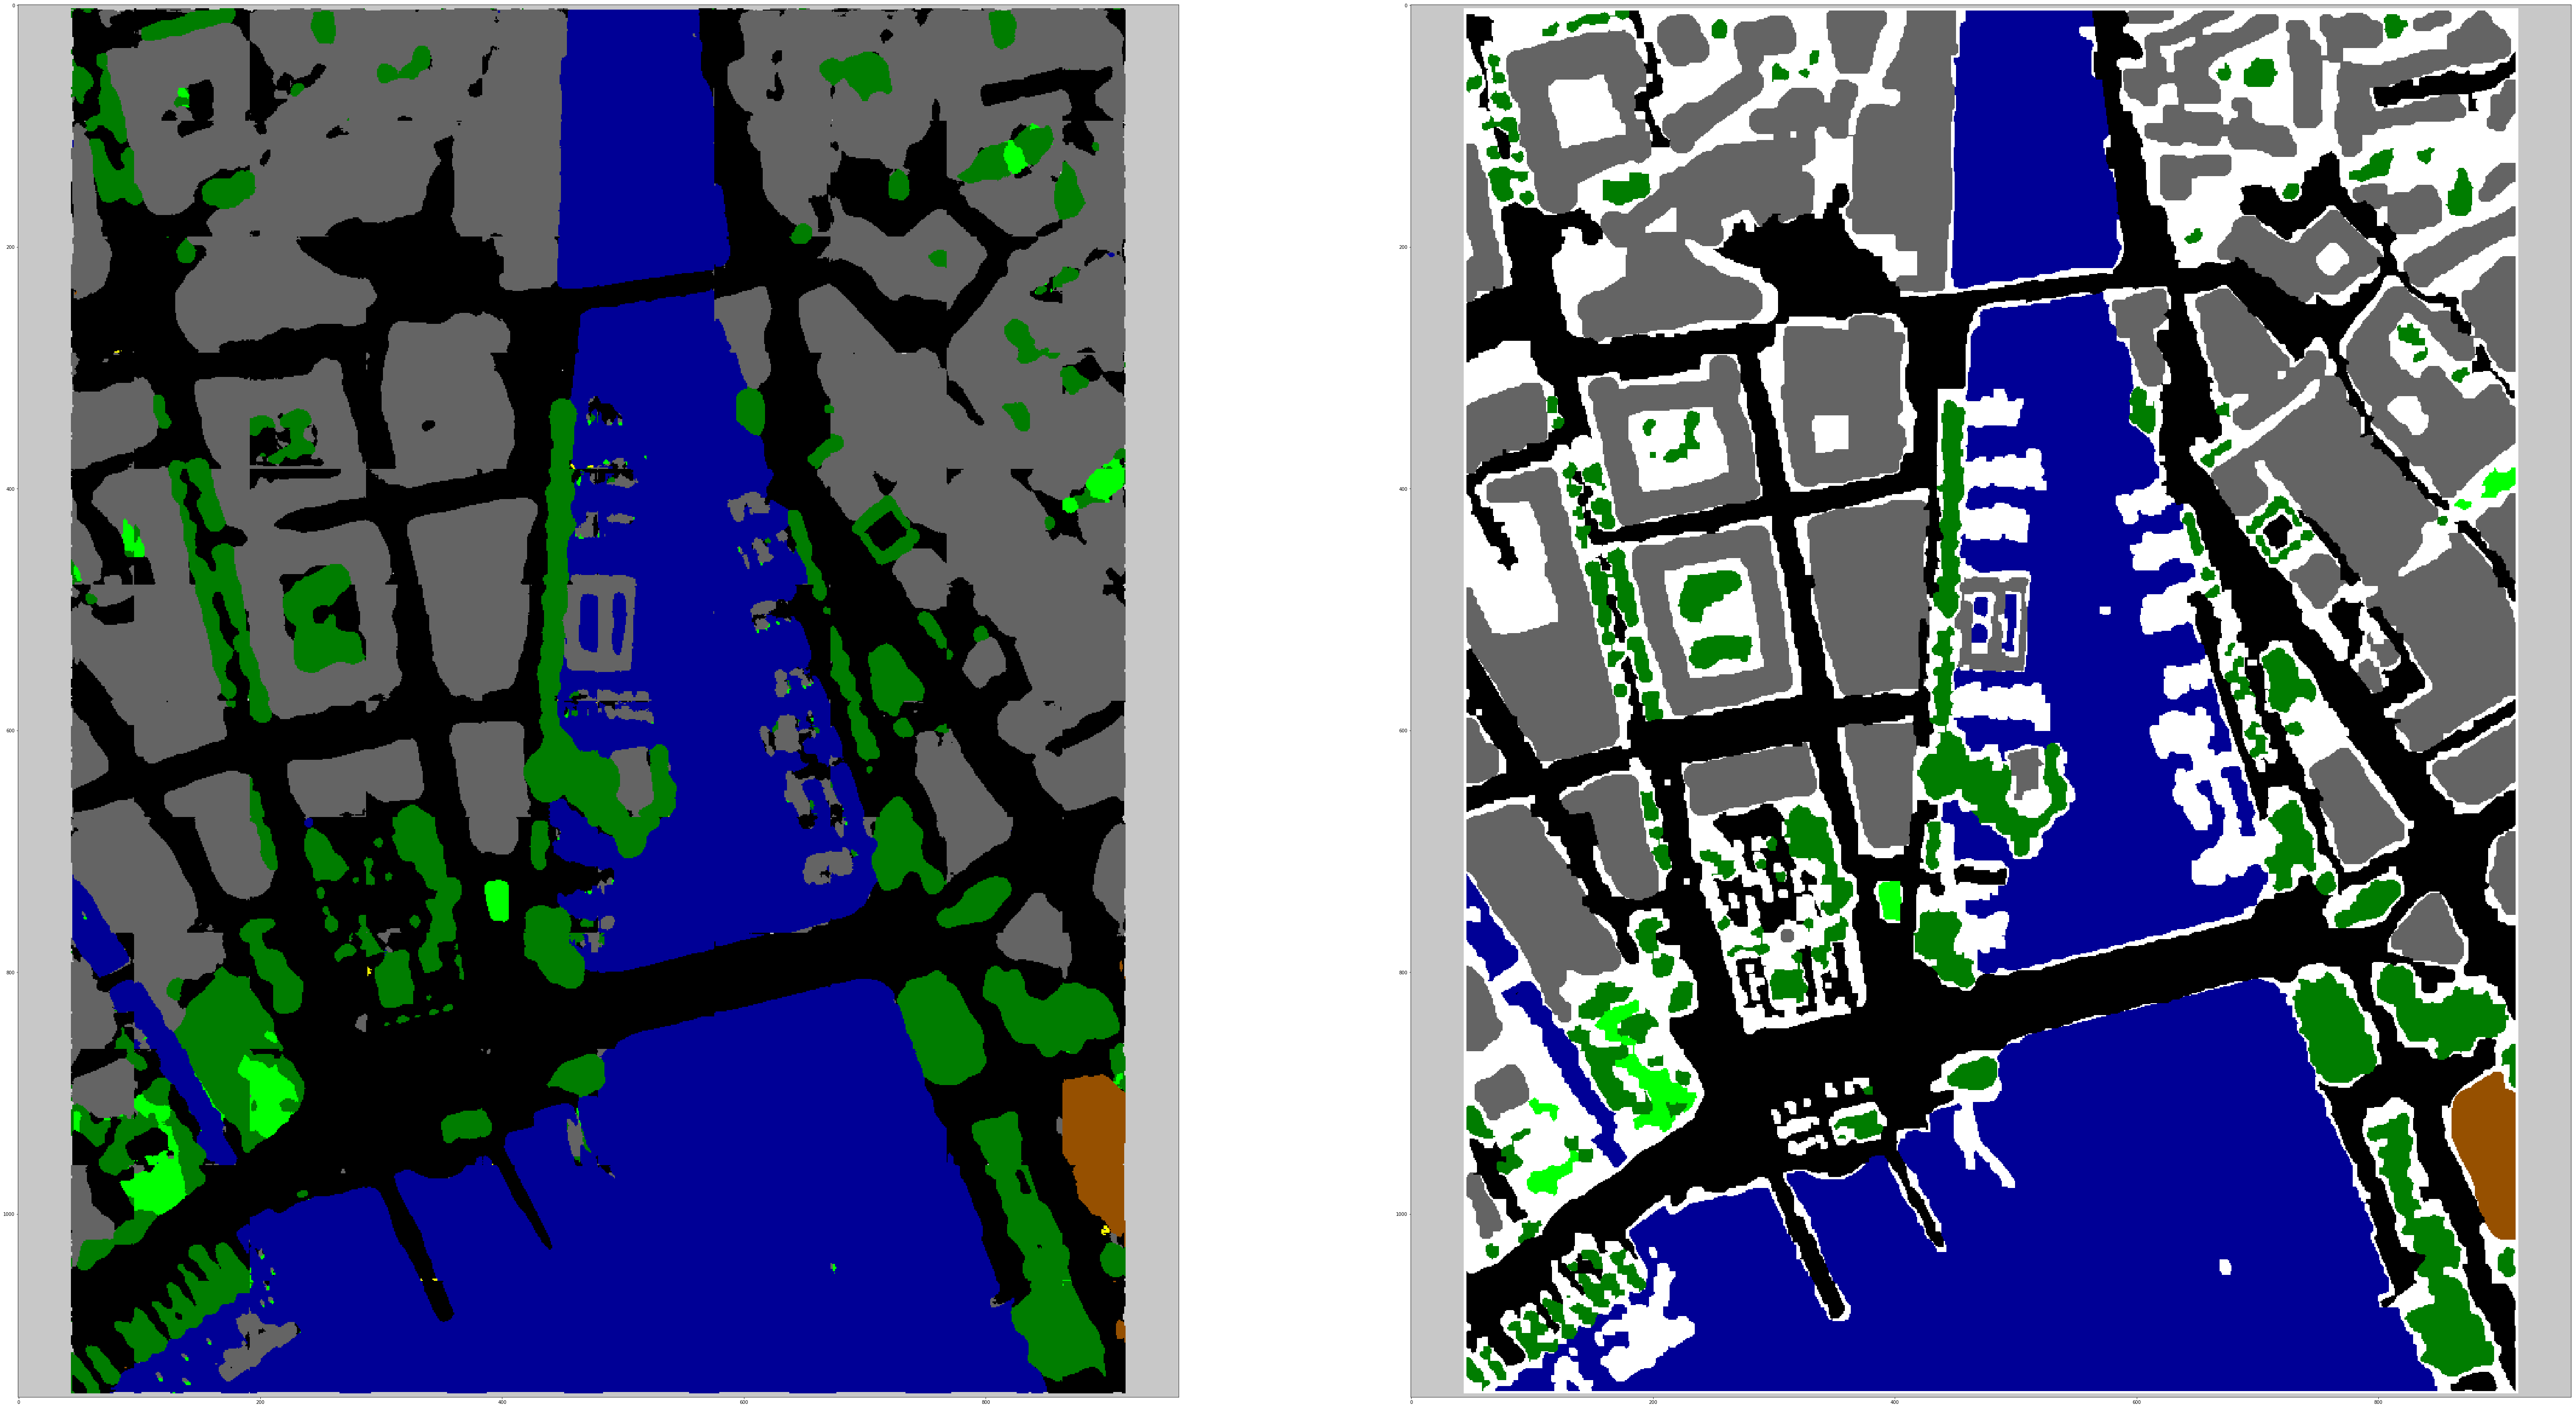

[[208150    222    526     68   6371    287      0     26]
 [   274   4936      0      0     69      2      0     34]
 [   991      0  61307    367    191     66      0      0]
 [    11      0   1093   3166      3      0      0      0]
 [  4980      4     98      6 238648     80      0      0]
 [   549      0     92     13    158 251146      0      2]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]]
Accuracy is 0.9788464874683648 while leaving Image8
Running for Image 9
Train on 1346 samples, validate on 578 samples
Epoch 1/30
1346/1346 [==============================] - 12s 9ms/step - loss: 1.6574 - jaccard_coef: 0.1720 - jaccard_coef_int: 0.1055 - acc: 0.4374 - val_loss: 1.8973 - val_jaccard_coef: 0.1793 - val_jaccard_coef_int: 0.1212 - val_acc: 0.3721

Epoch 00001: val_acc improved from -inf to 0.37212, saving model to ../cv_weights/cv_weights_v_9.best.hdf5
Epoch 2/30
1346/1346 [==============================] - 5

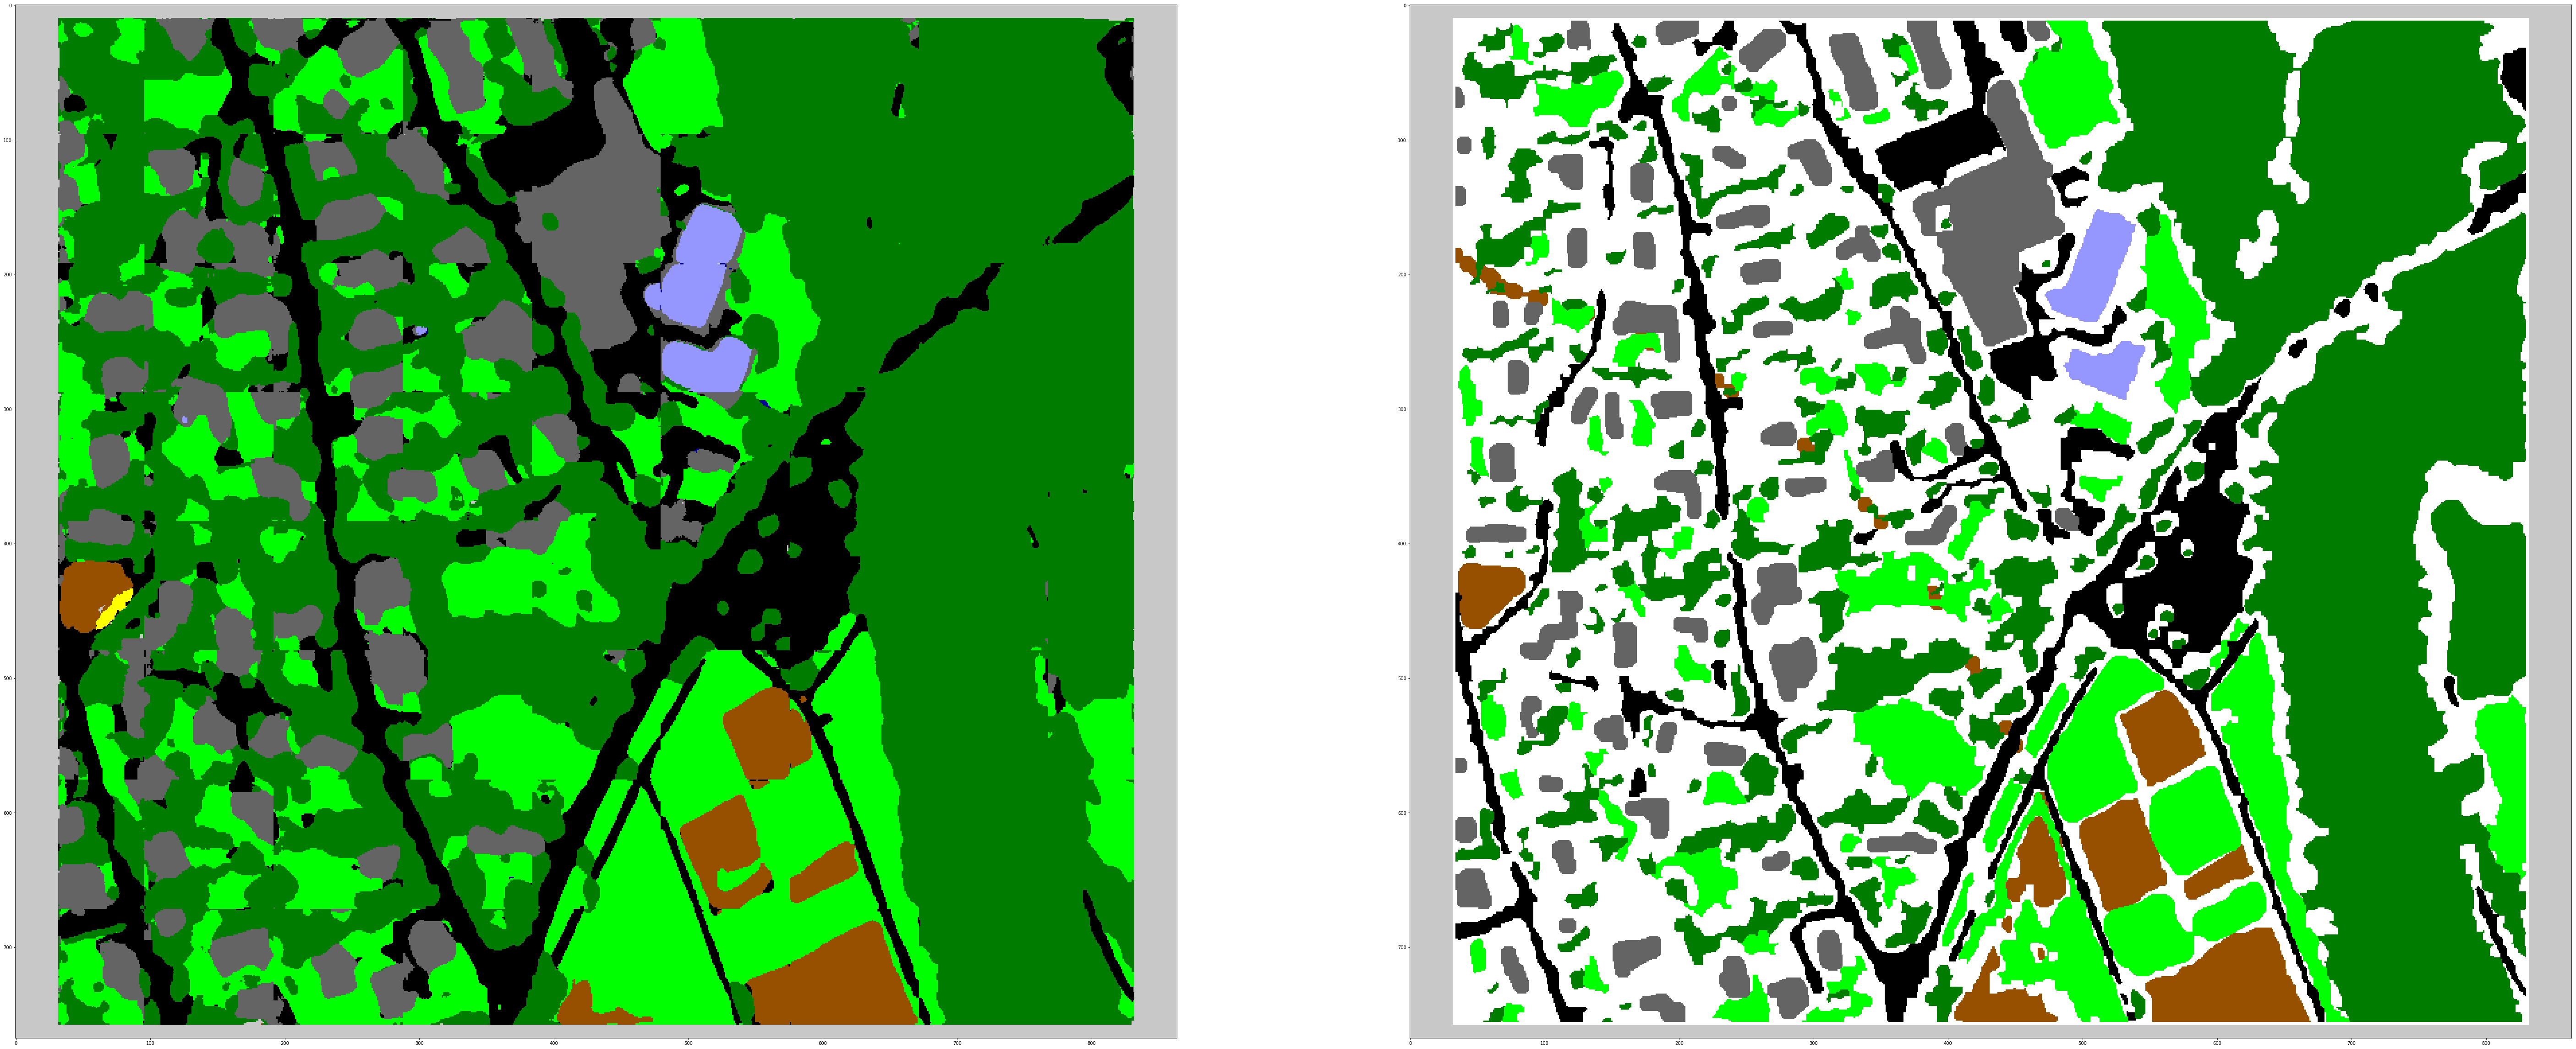

[[ 47626    129   1678    643    964      2     11    128]
 [   229  15002    910   3568    175      0      0     44]
 [    94      0 182758   2167    117      0      0      0]
 [   141    134   1612  63738      6      5      0      0]
 [   460      0    195    229  39334      0     16      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      8      0     63     15   4317      0]
 [     0      0      0      0      0      0      0      0]]
Accuracy is 0.9625038879400193 while leaving Image9
Running for Image 10
Train on 1369 samples, validate on 587 samples
Epoch 1/30
1369/1369 [==============================] - 13s 9ms/step - loss: 1.6496 - jaccard_coef: 0.1672 - jaccard_coef_int: 0.0862 - acc: 0.4520 - val_loss: 1.6923 - val_jaccard_coef: 0.1474 - val_jaccard_coef_int: 0.0578 - val_acc: 0.3800

Epoch 00001: val_acc improved from -inf to 0.37998, saving model to ../cv_weights/cv_weights_v_10.best.hdf5
Epoch 2/30
1369/1369 [==============================] -


Epoch 00024: val_acc did not improve from 0.72417
Epoch 25/30
1369/1369 [==============================] - 5s 3ms/step - loss: 0.5470 - jaccard_coef: 0.5277 - jaccard_coef_int: 0.6010 - acc: 0.7811 - val_loss: 0.8788 - val_jaccard_coef: 0.4508 - val_jaccard_coef_int: 0.4881 - val_acc: 0.6808

Epoch 00025: val_acc did not improve from 0.72417
Epoch 26/30
1369/1369 [==============================] - 5s 3ms/step - loss: 0.5156 - jaccard_coef: 0.5468 - jaccard_coef_int: 0.6244 - acc: 0.7941 - val_loss: 0.7933 - val_jaccard_coef: 0.4669 - val_jaccard_coef_int: 0.5123 - val_acc: 0.7057

Epoch 00026: val_acc did not improve from 0.72417
Epoch 27/30
1369/1369 [==============================] - 5s 3ms/step - loss: 0.5283 - jaccard_coef: 0.5359 - jaccard_coef_int: 0.6094 - acc: 0.7866 - val_loss: 0.7776 - val_jaccard_coef: 0.4725 - val_jaccard_coef_int: 0.5304 - val_acc: 0.7118

Epoch 00027: val_acc did not improve from 0.72417
Epoch 28/30
1369/1369 [==============================] - 5s 3ms/ste

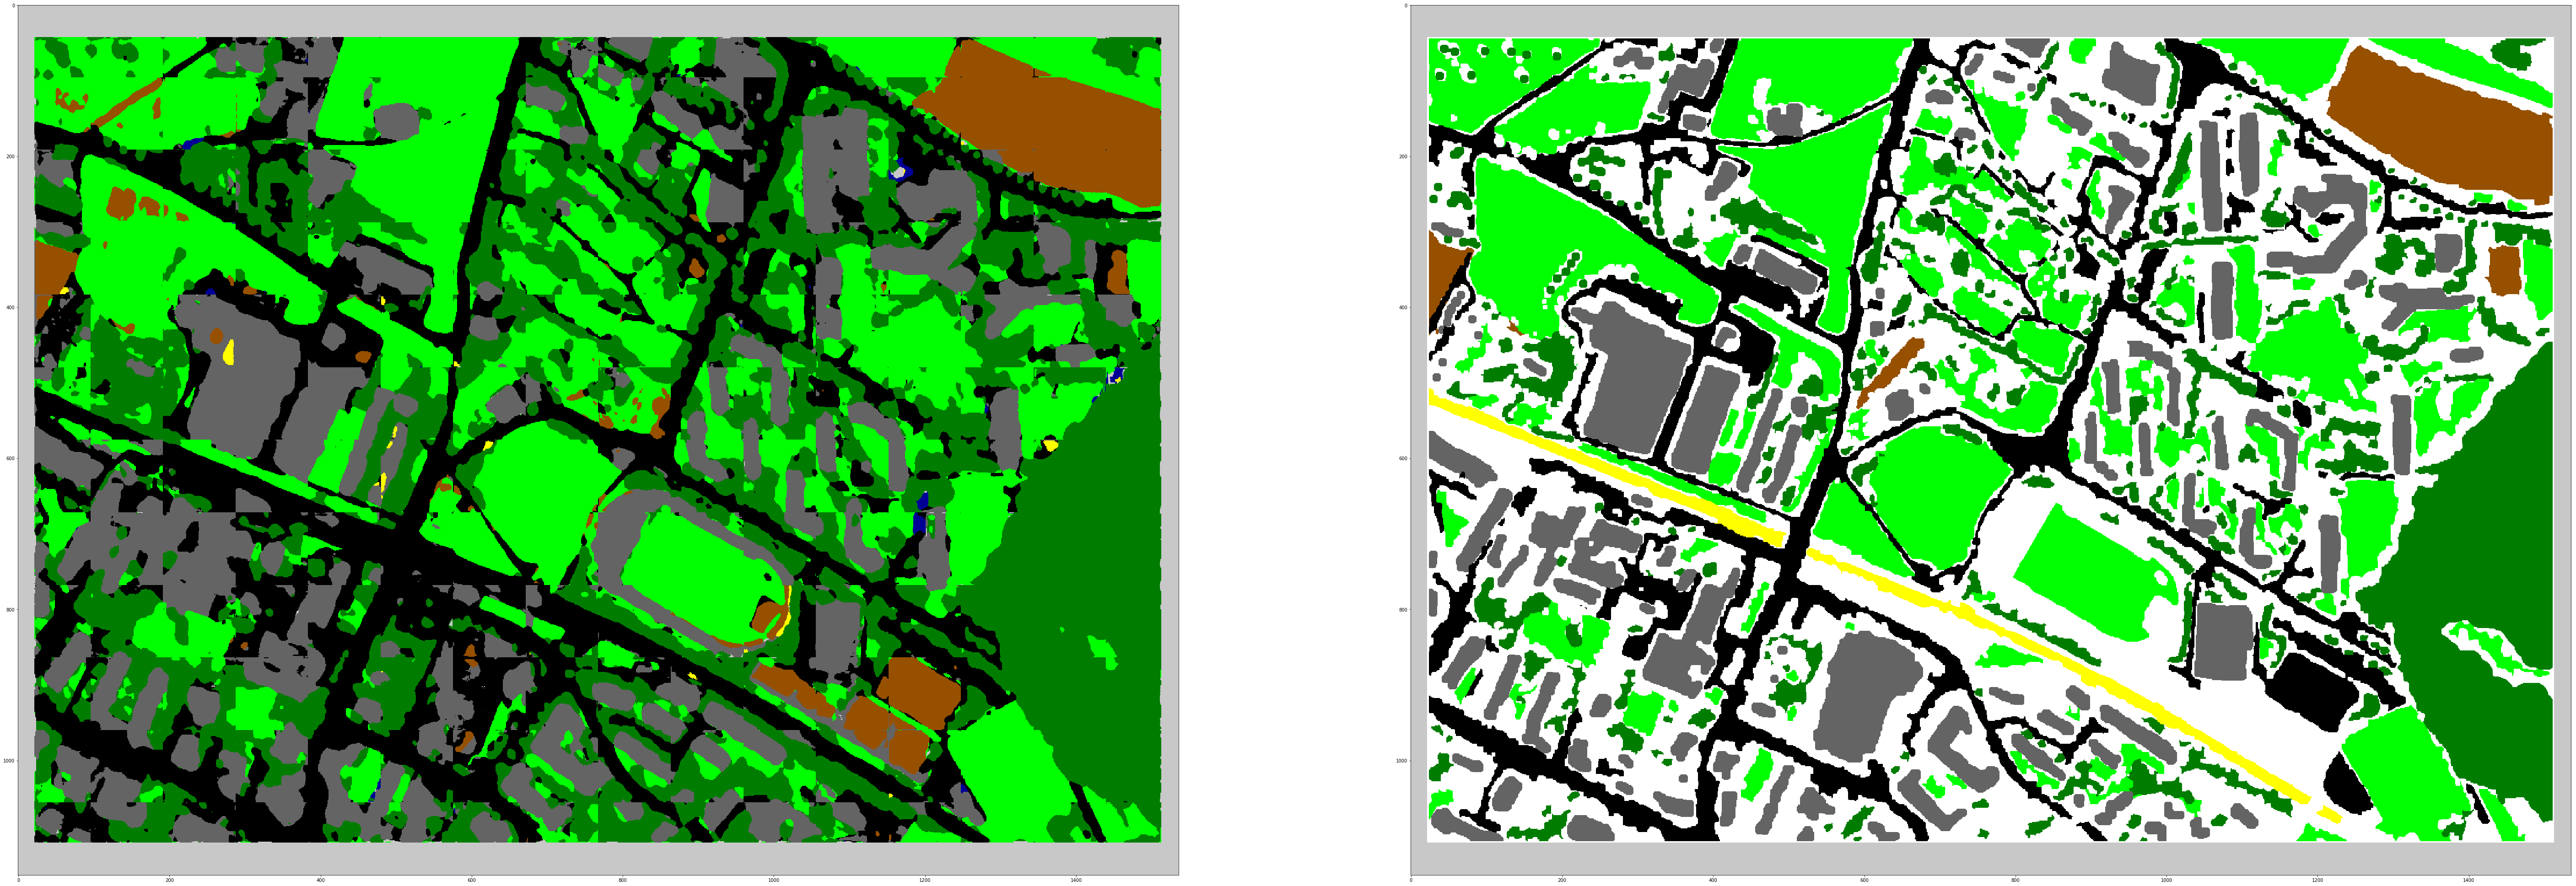

[[171963  10259   3909   6303  11267    299      0     90]
 [  1401  39213     98   2144    303      0      0      1]
 [   798      0 190521   4873    165      3      0      5]
 [  1744   4338  16973 300471    815      0      0      0]
 [ 16218    850   1746   1290 165675      8      0    572]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [ 17295      0    140     49   1271      0      0     62]]
Accuracy is 0.8918677014012487 while leaving Image10
Running for Image 11
Train on 1453 samples, validate on 623 samples
Epoch 1/30
1453/1453 [==============================] - 14s 10ms/step - loss: 1.6392 - jaccard_coef: 0.1716 - jaccard_coef_int: 0.0949 - acc: 0.4513 - val_loss: 1.7723 - val_jaccard_coef: 0.2480 - val_jaccard_coef_int: 0.2376 - val_acc: 0.5084

Epoch 00001: val_acc improved from -inf to 0.50836, saving model to ../cv_weights/cv_weights_v_11.best.hdf5
Epoch 2/30
1453/1453 [==============================]


Epoch 00025: val_acc did not improve from 0.70657
Epoch 26/30
1453/1453 [==============================] - 5s 4ms/step - loss: 0.4734 - jaccard_coef: 0.5790 - jaccard_coef_int: 0.6557 - acc: 0.8097 - val_loss: 0.8209 - val_jaccard_coef: 0.4629 - val_jaccard_coef_int: 0.5036 - val_acc: 0.7007

Epoch 00026: val_acc did not improve from 0.70657
Epoch 27/30
1453/1453 [==============================] - 5s 4ms/step - loss: 0.4863 - jaccard_coef: 0.5651 - jaccard_coef_int: 0.6416 - acc: 0.8028 - val_loss: 0.8088 - val_jaccard_coef: 0.4998 - val_jaccard_coef_int: 0.5393 - val_acc: 0.7199

Epoch 00027: val_acc improved from 0.70657 to 0.71990, saving model to ../cv_weights/cv_weights_v_11.best.hdf5
Epoch 28/30
1453/1453 [==============================] - 5s 4ms/step - loss: 0.4629 - jaccard_coef: 0.5823 - jaccard_coef_int: 0.6619 - acc: 0.8145 - val_loss: 0.8383 - val_jaccard_coef: 0.4812 - val_jaccard_coef_int: 0.5198 - val_acc: 0.7052

Epoch 00028: val_acc did not improve from 0.71990
Epoch 

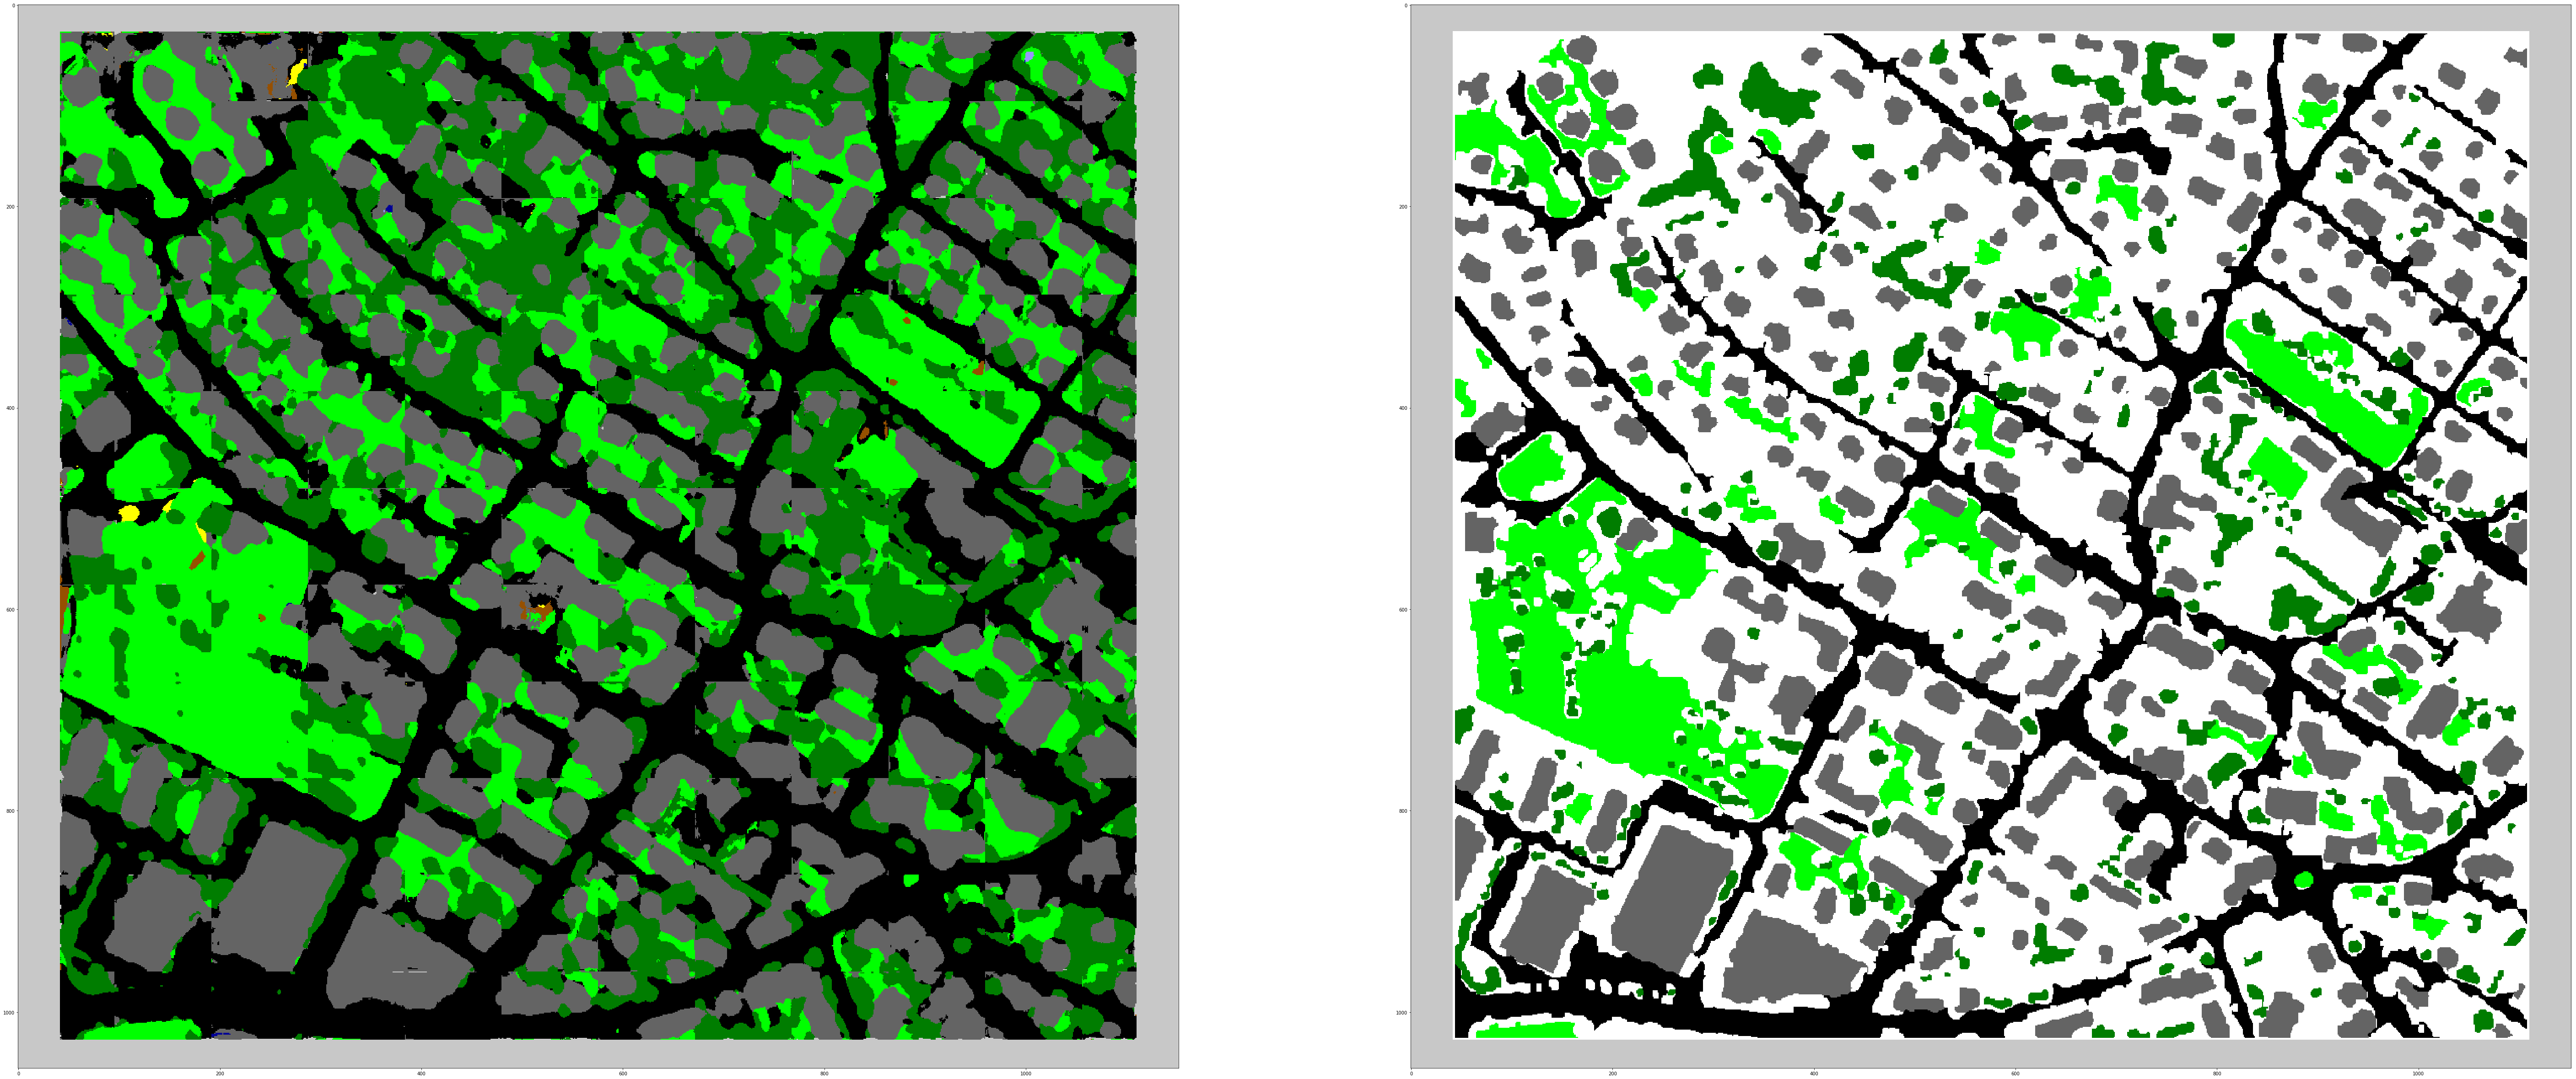

[[154007      1    841    600   3636      0      0    261]
 [     0      0      0      0      0      0      0      0]
 [   473      0  53884   2791    268      0      0      0]
 [   604     52   4002  82706    604      0      0     13]
 [  1460      1    256    235 168872      3      0      1]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]]
Accuracy is 0.9661417538075282 while leaving Image11
Running for Image 12
Train on 1434 samples, validate on 615 samples
Epoch 1/30
1434/1434 [==============================] - 15s 10ms/step - loss: 1.6444 - jaccard_coef: 0.1739 - jaccard_coef_int: 0.0985 - acc: 0.4505 - val_loss: 1.9154 - val_jaccard_coef: 0.1845 - val_jaccard_coef_int: 0.1380 - val_acc: 0.3617

Epoch 00001: val_acc improved from -inf to 0.36166, saving model to ../cv_weights/cv_weights_v_12.best.hdf5
Epoch 2/30
1434/1434 [==============================]

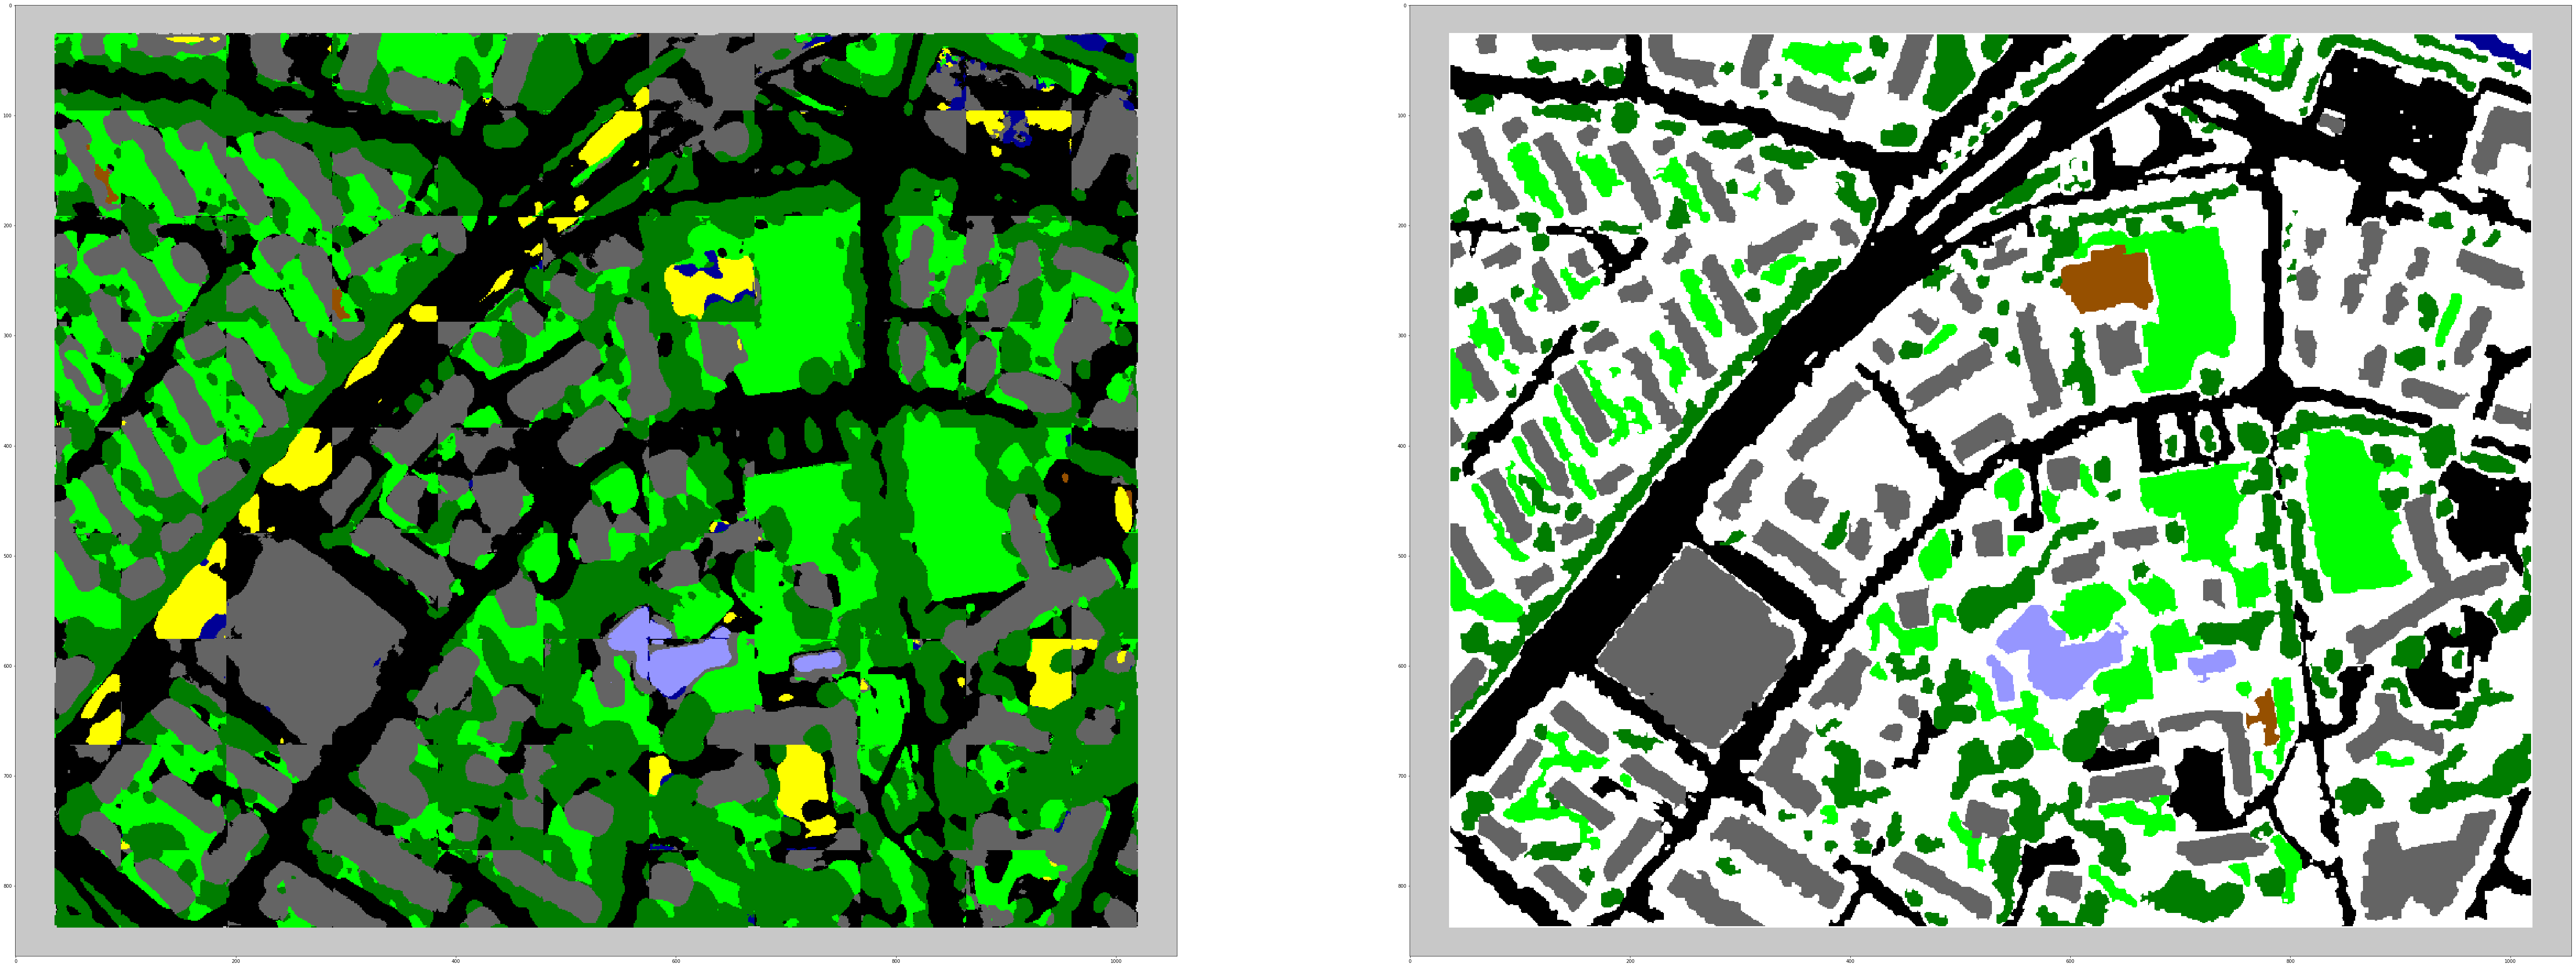

[[116549    106   2565    635  14402   1497      0  15425]
 [   132      0    283    970     89    708      0   2295]
 [   631      0  73423   3419    197      0      0     26]
 [   306      0   3182  60559    995      0      1      0]
 [  5755    533    655   3544 112500     86      0    312]
 [   203      0    185      3      3    438      0      0]
 [   318      0      8      0   1315    174   4433      0]
 [     0      0      0      0      0      0      0      0]]
Accuracy is 0.8578603740148301 while leaving Image12
Running for Image 13
Train on 1411 samples, validate on 605 samples
Epoch 1/30
1411/1411 [==============================] - 15s 11ms/step - loss: 1.5736 - jaccard_coef: 0.1858 - jaccard_coef_int: 0.1159 - acc: 0.4716 - val_loss: 1.4277 - val_jaccard_coef: 0.3042 - val_jaccard_coef_int: 0.3155 - val_acc: 0.5446

Epoch 00001: val_acc improved from -inf to 0.54465, saving model to ../cv_weights/cv_weights_v_13.best.hdf5
Epoch 2/30
1411/1411 [==============================]

1411/1411 [==============================] - 5s 4ms/step - loss: 0.4528 - jaccard_coef: 0.5876 - jaccard_coef_int: 0.6686 - acc: 0.8189 - val_loss: 0.8931 - val_jaccard_coef: 0.4725 - val_jaccard_coef_int: 0.5125 - val_acc: 0.6887

Epoch 00025: val_acc did not improve from 0.71872
Epoch 26/30
1411/1411 [==============================] - 5s 4ms/step - loss: 0.4256 - jaccard_coef: 0.6053 - jaccard_coef_int: 0.6864 - acc: 0.8293 - val_loss: 0.7738 - val_jaccard_coef: 0.4986 - val_jaccard_coef_int: 0.5458 - val_acc: 0.7200

Epoch 00026: val_acc improved from 0.71872 to 0.72005, saving model to ../cv_weights/cv_weights_v_13.best.hdf5
Epoch 27/30
1411/1411 [==============================] - 5s 4ms/step - loss: 0.4173 - jaccard_coef: 0.6139 - jaccard_coef_int: 0.6936 - acc: 0.8324 - val_loss: 0.7837 - val_jaccard_coef: 0.4996 - val_jaccard_coef_int: 0.5397 - val_acc: 0.7207

Epoch 00027: val_acc improved from 0.72005 to 0.72069, saving model to ../cv_weights/cv_weights_v_13.best.hdf5
Epoch 28

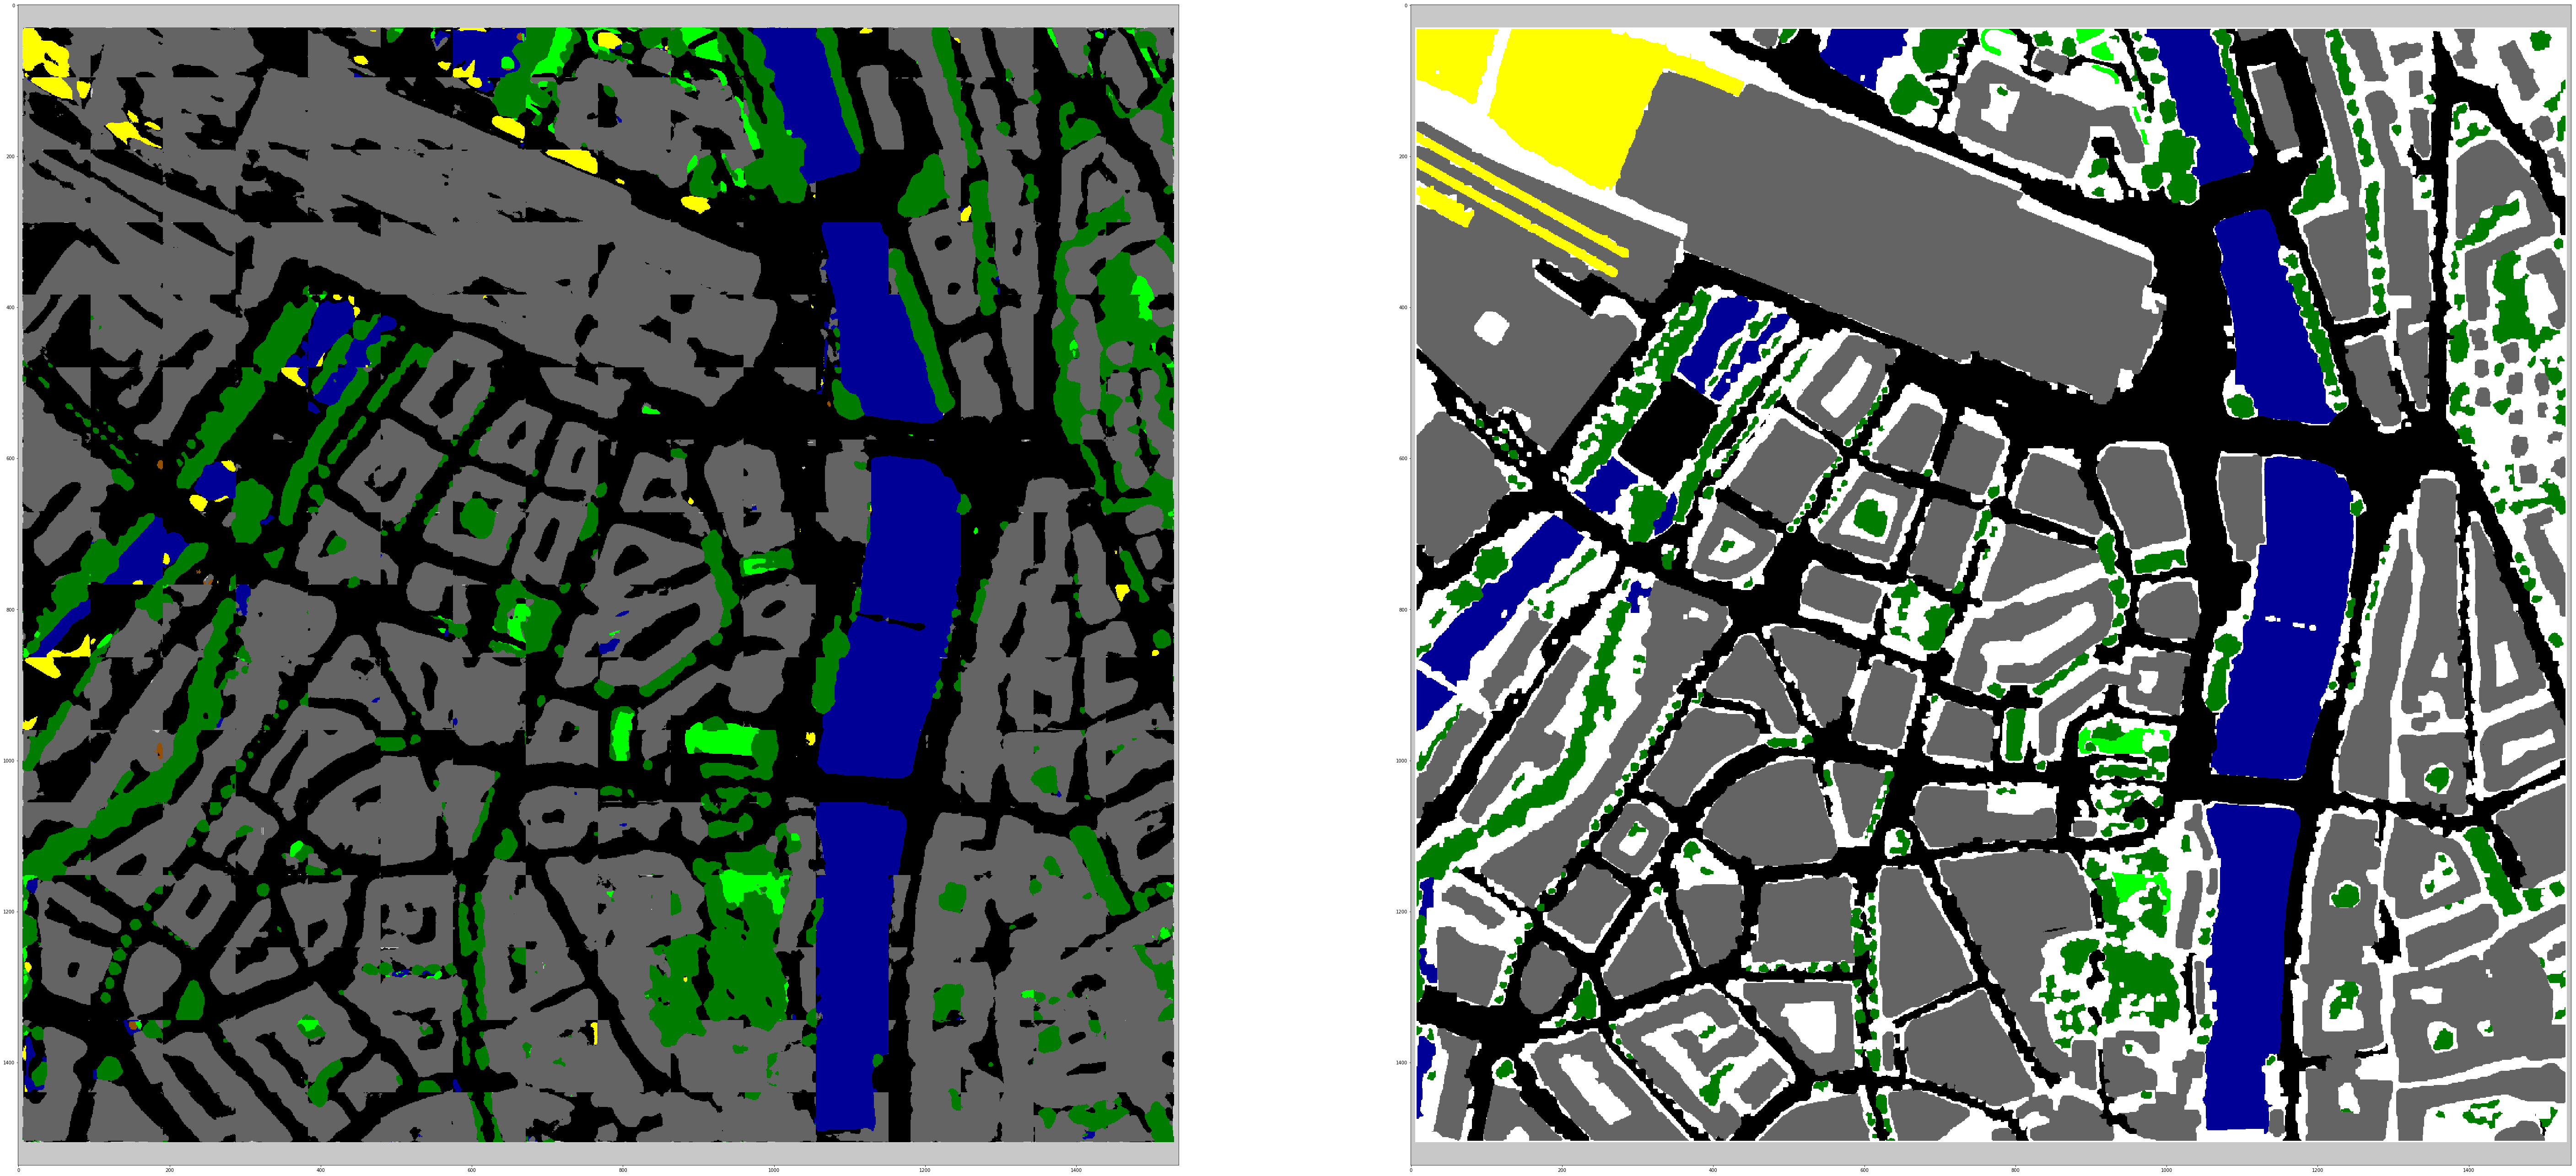

[[403754    207   4360    516  46049   1976      0   2805]
 [     0      0      0      0      0      0      0      0]
 [  4480      0 127112   4319   1883     91      0     24]
 [   168      0    355   5241     17      0      0      0]
 [103818    143   2828    140 818703    710      0    546]
 [ 15029      0    752      1   1622 147092      0   3490]
 [     0      0      0      0      0      0      0      0]
 [ 14027      0      0      0  36101     12      0   4682]]
Accuracy is 0.8594058479692286 while leaving Image13
Running for Image 14
Train on 1356 samples, validate on 582 samples
Epoch 1/30
1356/1356 [==============================] - 15s 11ms/step - loss: 1.6088 - jaccard_coef: 0.1773 - jaccard_coef_int: 0.1018 - acc: 0.4501 - val_loss: 1.7347 - val_jaccard_coef: 0.2433 - val_jaccard_coef_int: 0.2237 - val_acc: 0.4818

Epoch 00001: val_acc improved from -inf to 0.48178, saving model to ../cv_weights/cv_weights_v_14.best.hdf5
Epoch 2/30
1356/1356 [==============================]

1356/1356 [==============================] - 5s 4ms/step - loss: 0.4191 - jaccard_coef: 0.6131 - jaccard_coef_int: 0.6926 - acc: 0.8324 - val_loss: 0.8459 - val_jaccard_coef: 0.4816 - val_jaccard_coef_int: 0.5239 - val_acc: 0.7058

Epoch 00025: val_acc did not improve from 0.72342
Epoch 26/30
1356/1356 [==============================] - 5s 4ms/step - loss: 0.4061 - jaccard_coef: 0.6235 - jaccard_coef_int: 0.7007 - acc: 0.8372 - val_loss: 0.8447 - val_jaccard_coef: 0.4962 - val_jaccard_coef_int: 0.5355 - val_acc: 0.7106

Epoch 00026: val_acc did not improve from 0.72342
Epoch 27/30
1356/1356 [==============================] - 5s 4ms/step - loss: 0.4097 - jaccard_coef: 0.6181 - jaccard_coef_int: 0.6966 - acc: 0.8346 - val_loss: 0.9865 - val_jaccard_coef: 0.4395 - val_jaccard_coef_int: 0.4733 - val_acc: 0.6519

Epoch 00027: val_acc did not improve from 0.72342
Epoch 28/30
1356/1356 [==============================] - 5s 4ms/step - loss: 0.3984 - jaccard_coef: 0.6258 - jaccard_coef_int: 0.7

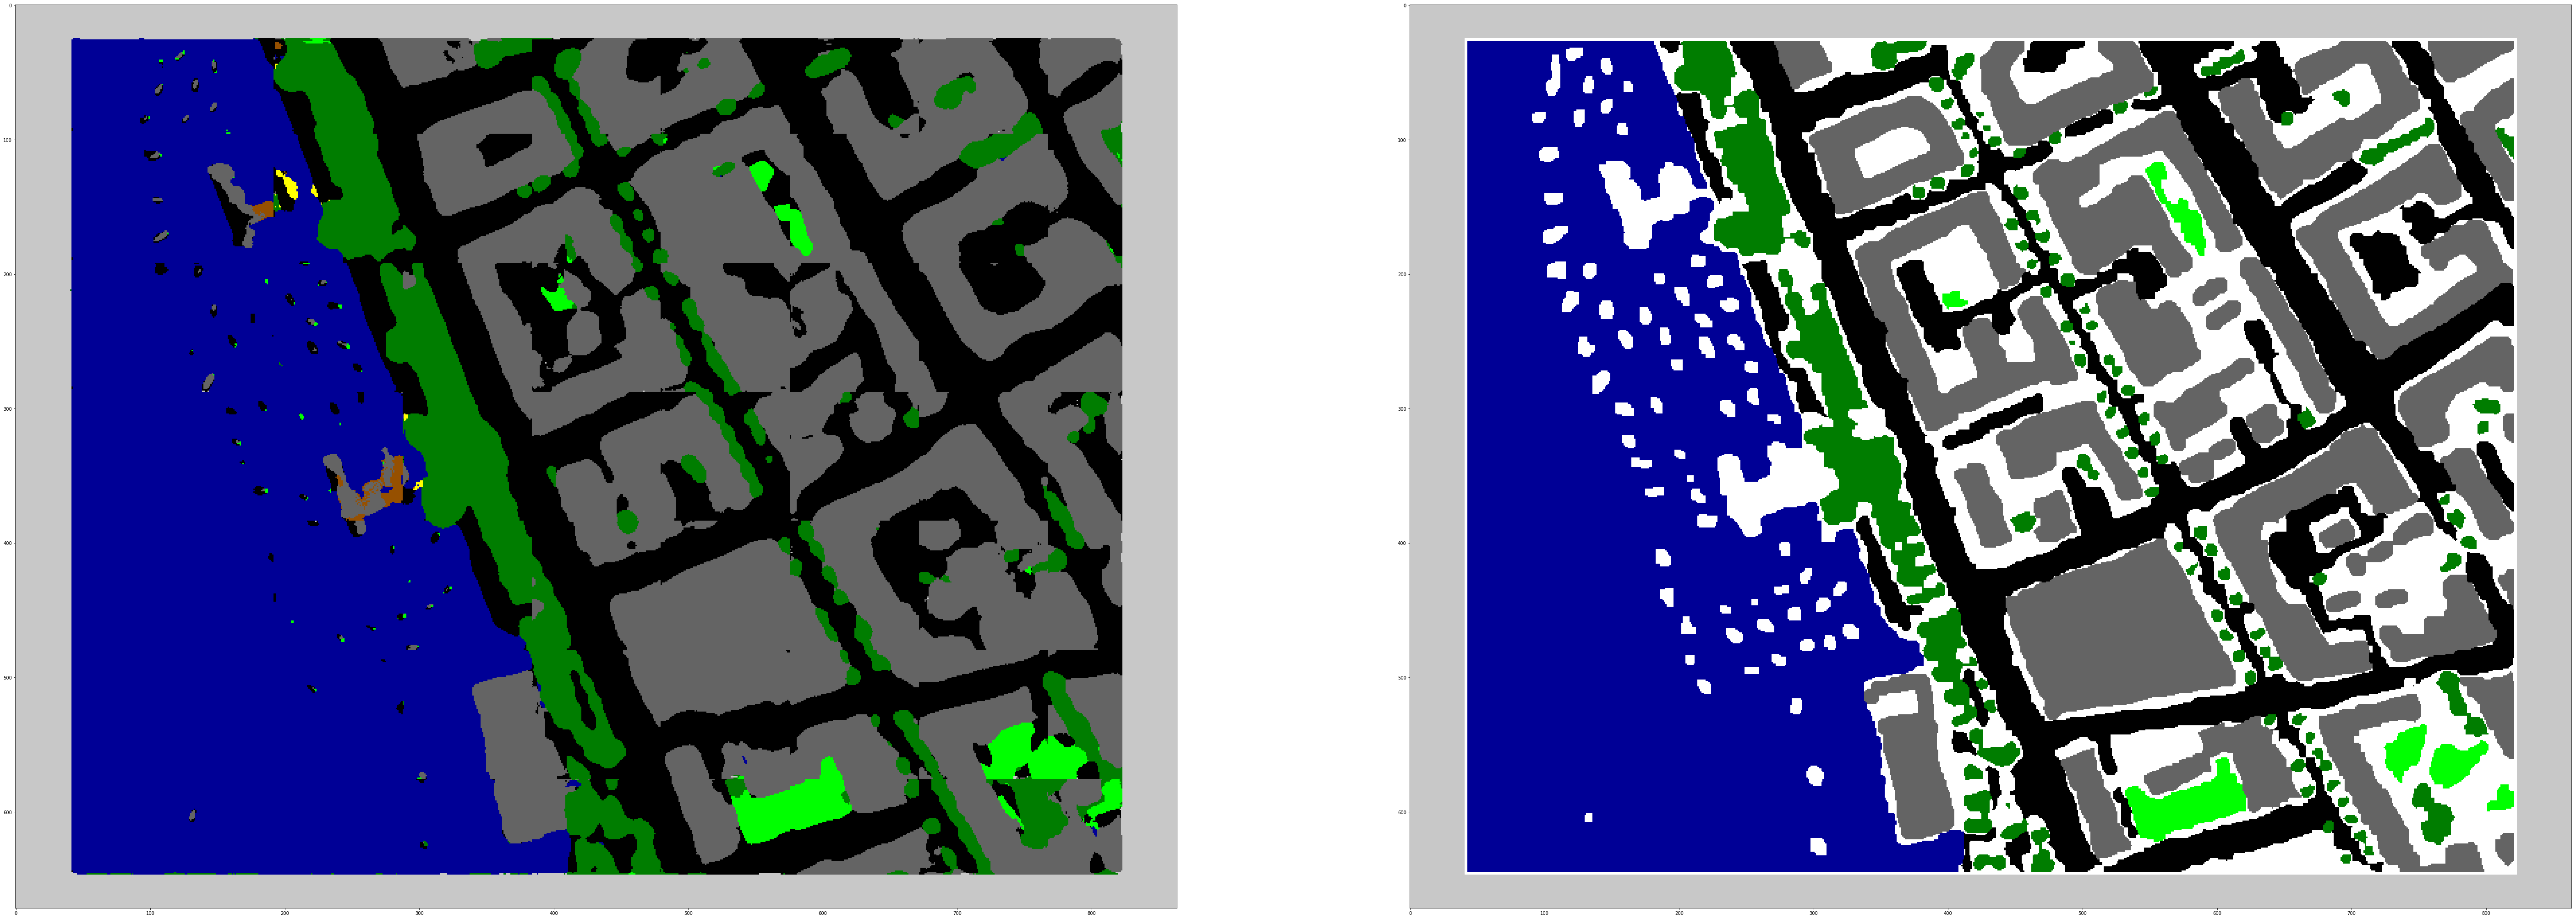

[[ 83112     24    381     16   3191     19      0      0]
 [     0      0      0      0      0      0      0      0]
 [   433      0  26078     47    184      2      0      0]
 [   166      0    325   5159    101      0      0      0]
 [  1767      0     79      0 113052     34      0      0]
 [    64      0     51     13     40 142019      0     10]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]]
Accuracy is 0.9815419524028408 while leaving Image14


In [21]:
#Excluding one image everytime for the model.
for img_id in range(1,15):
    print("Running for Image "+str(img_id))

    X = np.zeros((1,96,96,5))
    y = np.zeros((1,96,96,10))
    for i in range(1,15):
        if i!=img_id:
            
            x_arr = np.load("arrays/individual/X_"+str(i)+".npy")
            y_arr = np.load("arrays/individual/y_"+str(i)+".npy")
            
            X = np.concatenate((x_arr,X),axis=0)
            y = np.concatenate((y_arr,y),axis=0)

    X = X[1:]
    y = y[1:]

    v_x = np.load("arrays/individual/X_"+str(img_id)+".npy")
    v_y = np.load("arrays/individual/y_"+str(img_id)+".npy")
    
    X = X/4096.0
    v_x = v_x/4096.0
    
    


    from sklearn.model_selection import train_test_split




    model = get_unet()
    scratch=True
    filepath='cv_weights/cv_weights_v_'+str(img_id)+'.best.hdf5'

    if not scratch:
        model.load_weights(filepath)


    

    sgd = keras.optimizers.SGD(lr=.001)

    
    
    #Training
    
    
    
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    model.fit([X,np.expand_dims(X[:,:,:,4],axis=3),np.expand_dims(X[:,:,:,3],axis=3)] ,y, validation_split=.3, epochs=30, batch_size=80 , callbacks=callbacks_list)
    
    model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    model.fit([X,np.expand_dims(X[:,:,:,4],axis=3),np.expand_dims(X[:,:,:,3],axis=3)] ,y, validation_split=.3, epochs=10, batch_size=80 , callbacks=callbacks_list)
    
    #Testing
    
    
    img_name = str(img_id)+".tif"
    img_path = 'arrays/train_x/'+img_name
    
    img1,img2 = generate_whole_mask(img_path,filepath)
    
    
    
    %matplotlib inline
    gen = inverse_map(img1)
    truth = inverse_map(img2)
    plt.close('all')
    plt.figure(figsize=(100,100))
    plt.subplot(1,2,1)
    plt.imshow(gen)
    plt.subplot(1,2,2)
    plt.imshow(truth)
    plt.show()
    
    cf = confusion_matrix(img2.flatten(),img1.flatten(),labels=[0,1,2,3,4,5,7,9])
    print (cf)
    
    print ("Accuracy is "+str(np.trace(cf)/np.sum(cf)*1.0)+" while leaving Image"+str(img_id))
    
    






    
    
    
    
    